In [ ]:
from google.colab import files
upload = files.upload()

Saving functions.py to functions.py


In [ ]:
import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

install("keras_tuner")
install("scikeras")
install("pandas_ta")
install("fredapi")
install("hyperopt")
install('quantstats')

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import pandas as pd
import numpy as np
from numpy import sort
import yfinance as yf
import tensorflow as tf
from functions import *
import quantstats as qs
from tensorflow.keras.models import load_model

SEED = 123
DATA_SPLIT_PCT = 0.2

# Set the random seed for reproducibility
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 1. DATA COLLECTION



## 1a. Historical Price Data

In [ ]:
# Import Close Price, Volume, Open Price, High Price, Low Price
## Fetch ETH stock data
symbols = ['ETH-USD']
start_date = '2014-01-01'
end_date = '2024-08-01'
price_data = download_yahoo_finance(symbols,start_date=start_date,end_date=end_date)
price_data = price_data[['Open', 'High', 'Low', 'Close', 'Volume']]
price_data['Volume'] = price_data['Volume'].astype(float)

## Calculate perchange change for lag 1
price_data = lag_data(price_data)
price_data.head()

[*********************100%***********************]  1 of 1 completed


Open        High         Low       Close        Volume  \
Date                                                                       
2017-11-09  308.644989  329.451996  307.056000  320.884003  8.932500e+08   
2017-11-10  320.670990  324.717987  294.541992  299.252991  8.859860e+08   
2017-11-11  298.585999  319.453003  298.191986  314.681000  8.423010e+08   
2017-11-12  314.690002  319.153015  298.513000  307.907990  1.613480e+09   
2017-11-13  307.024994  328.415009  307.024994  316.716003  1.041890e+09   

            Open_lag1  High_lag1  Low_lag1  Close_lag1  Volume_lag1  
Date                                                                 
2017-11-09        NaN        NaN       NaN         NaN          NaN  
2017-11-10   0.038964  -0.014369 -0.040755   -0.067411    -0.008132  
2017-11-11  -0.068871  -0.016214  0.012392    0.051555    -0.049307  
2017-11-12   0.053934  -0.000939  0.001077   -0.021523     0.915562  
2017-11-13  -0.024357   0.029021  0.028515    0.028606    -0.354259

## 1b. Technical Indicators

In [ ]:
price_data = calculate_indicators(price_data)
price_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2458 entries, 2017-11-09 to 2024-08-01
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Open            2458 non-null   float64
 1   High            2458 non-null   float64
 2   Low             2458 non-null   float64
 3   Close           2458 non-null   float64
 4   Volume          2458 non-null   float64
 5   Open_lag1       2457 non-null   float64
 6   High_lag1       2457 non-null   float64
 7   Low_lag1        2457 non-null   float64
 8   Close_lag1      2457 non-null   float64
 9   Volume_lag1     2457 non-null   float64
 10  Return_lag10    2448 non-null   float64
 11  RSI_14          2444 non-null   float64
 12  RSI_6           2452 non-null   float64
 13  RSI_5           2453 non-null   float64
 14  %K              2443 non-null   float64
 15  %D              2441 non-null   float64
 16  SMA5            2454 non-null   float64
 17  SMA10          

## 1c. Macroeconomic Data


In [ ]:
## Fetch macroeconomic data
symbols = ['BTC-USD','INR=X', 'CNY=X', 'BRL=X', 'VND=X', 'CL=F', 'GC=F', 'SI=F', '^GSPC', '^TNX', '^FVX']
macro_data = download_yahoo_finance(symbols, start_date, end_date)['Close']

## Convert both indexes to tz-aware DatetimeIndex
macro_data.index = macro_data.index.tz_localize(None)

## Rename
macro_data.rename(columns={
    'INR=X': 'USD/INR',
    'CNY=X': 'USD/CNY',
    'BRL=X': 'USD/BRL',
    'VND=X': 'USD/VND',
    'CL=F': 'Crude_Oil',
    'GC=F': 'Gold',
    '^GSPC': 'S&P500',
    'SI=F': 'Silver',
    '^FVX': '10Y_TB',
    '^TNX': '5Y_TB',}, inplace=True)

[*********************100%***********************]  11 of 11 completed


In [ ]:
macro_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2478 entries, 2014-09-17 to 2024-08-01
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   USD/BRL    2478 non-null   float64
 1   BTC-USD    2478 non-null   float64
 2   Crude_Oil  2478 non-null   float64
 3   USD/CNY    2478 non-null   float64
 4   Gold       2478 non-null   float64
 5   USD/INR    2478 non-null   float64
 6   Silver     2478 non-null   float64
 7   USD/VND    2478 non-null   float64
 8   10Y_TB     2478 non-null   float64
 9   S&P500     2478 non-null   float64
 10  5Y_TB      2478 non-null   float64
dtypes: float64(11)
memory usage: 232.3 KB


# 2. DATA PRE-PROCESSING

## 2a. Data Cleaning

In [ ]:
# Merge all data
eth_data = pd.concat([price_data, macro_data], axis=1, join="inner")
eth_data = eth_data.dropna()
eth_data.head()

Open        High         Low       Close        Volume  \
Date                                                                       
2017-12-12  522.286011  657.317993  504.493988  651.431030  5.179830e+09   
2017-12-13  644.906006  747.992981  597.797974  702.767029  4.524540e+09   
2017-12-14  700.593994  753.120972  664.989014  695.815979  3.821580e+09   
2017-12-15  696.375977  697.132019  621.060974  684.447998  2.758710e+09   
2017-12-18  721.731995  803.927979  689.231018  794.645020  3.249230e+09   

            Open_lag1  High_lag1  Low_lag1  Close_lag1  Volume_lag1  ...  \
Date                                                                 ...   
2017-12-12   0.186049   0.271484  0.148917    0.264581     1.924079  ...   
2017-12-13   0.234776   0.137947  0.184946    0.078805    -0.126508  ...   
2017-12-14   0.086351   0.006856  0.112398   -0.009891    -0.155366  ...   
2017-12-15  -0.006021  -0.074343 -0.066058   -0.016338    -0.278123  ...   
2017-12-18   0.036618   0.092553 -0.010063    0.103712     0.513107  ...   

                 BTC-USD  Crude_Oil  USD/CNY         Gold    USD/INR  \
Date                                                                   
2017-12-12  17415.400391  57.139999   6.6171  1238.500000  64.349998   
2017-12-13  16408.199219  56.599998   6.6204  1245.400024  64.550003   
2017-12-14  16564.000000  57.040001   6.6187  1253.800049  64.320000   
2017-12-15  17706.900391  57.299999   6.6086  1254.300049  64.275002   
2017-12-18  19114.199219  57.160000   6.6149  1262.199951  64.072304   

               Silver  USD/VND  10Y_TB       S&P500  5Y_TB  
Date                                                        
2017-12-12  15.582000  22441.0   2.172  2664.110107  2.403  
2017-12-13  15.784000  22208.0   2.110  2662.850098  2.349  
2017-12-14  15.850000  22476.0   2.128  2652.010010  2.346  
2017-12-15  15.978000  22473.0   2.157  2675.810059  2.355  
2017-12-18  16.120001  22395.0   2.167  2690.159912  2.392  

[5 rows x 39 columns]

In [ ]:
eth_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1666 entries, 2017-12-12 to 2024-08-01
Data columns (total 39 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Open            1666 non-null   float64
 1   High            1666 non-null   float64
 2   Low             1666 non-null   float64
 3   Close           1666 non-null   float64
 4   Volume          1666 non-null   float64
 5   Open_lag1       1666 non-null   float64
 6   High_lag1       1666 non-null   float64
 7   Low_lag1        1666 non-null   float64
 8   Close_lag1      1666 non-null   float64
 9   Volume_lag1     1666 non-null   float64
 10  Return_lag10    1666 non-null   float64
 11  RSI_14          1666 non-null   float64
 12  RSI_6           1666 non-null   float64
 13  RSI_5           1666 non-null   float64
 14  %K              1666 non-null   float64
 15  %D              1666 non-null   float64
 16  SMA5            1666 non-null   float64
 17  SMA10          

**Data Visualization**

<Figure size 1600x1000 with 0 Axes>

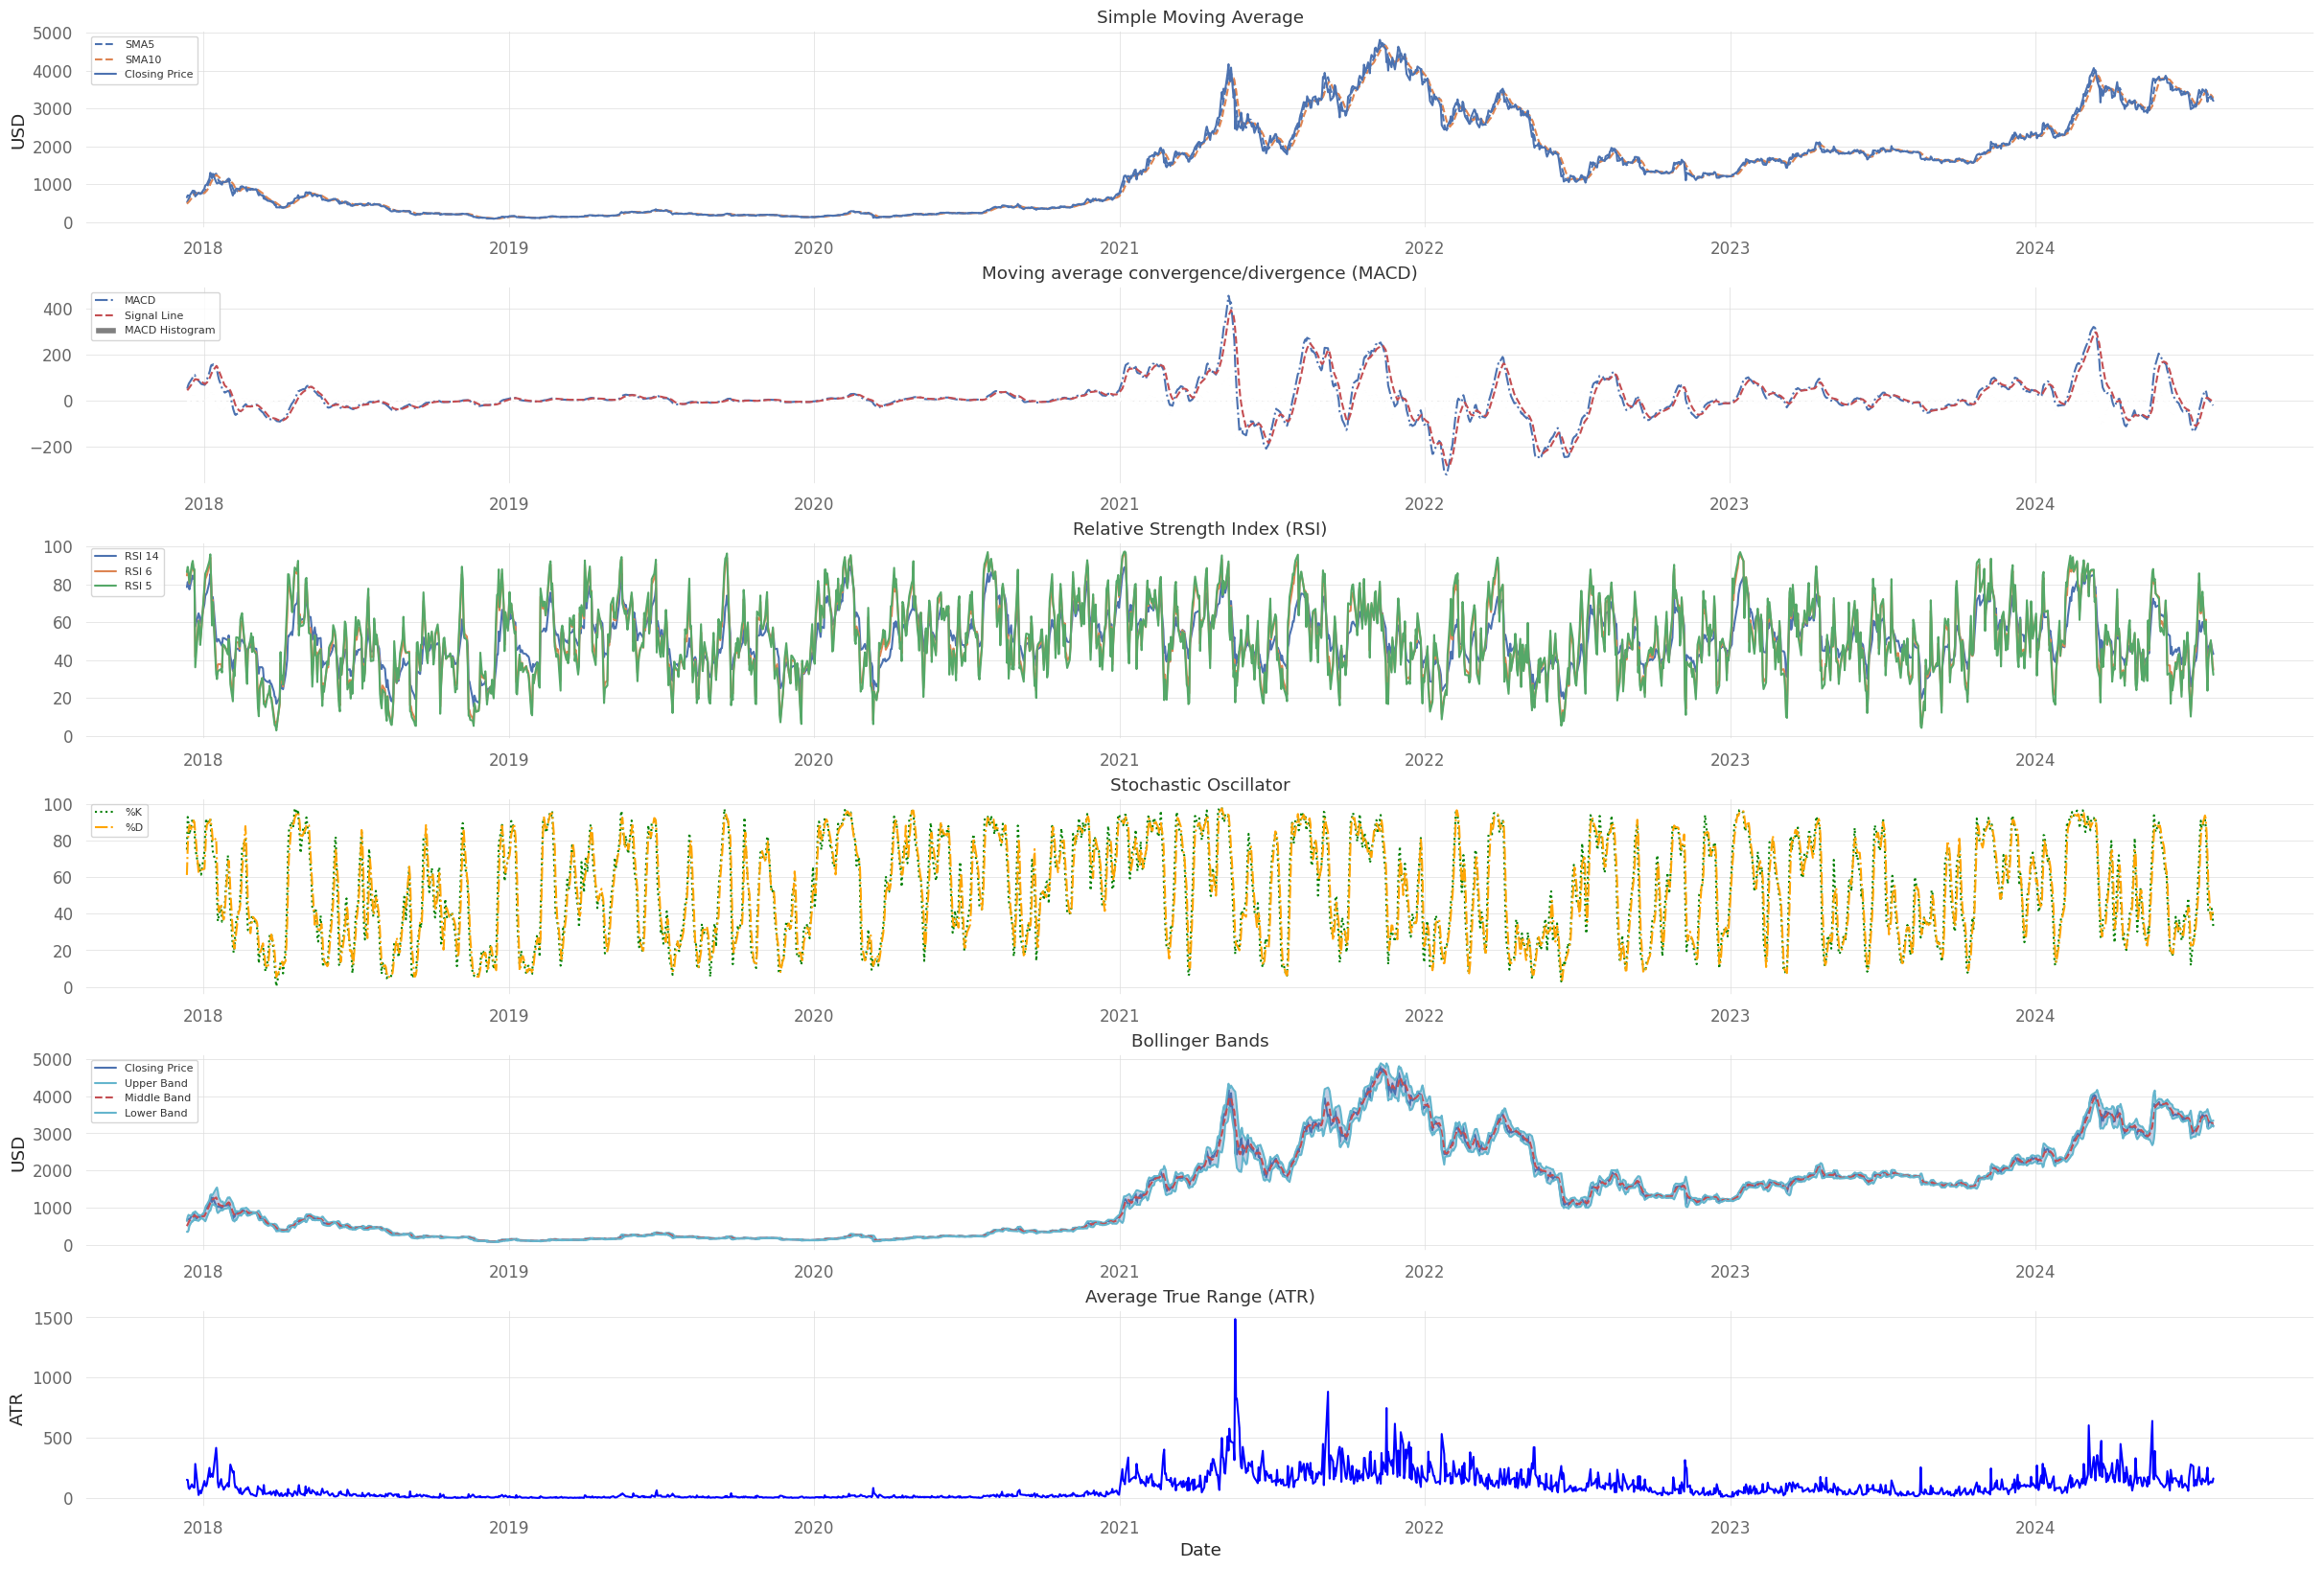

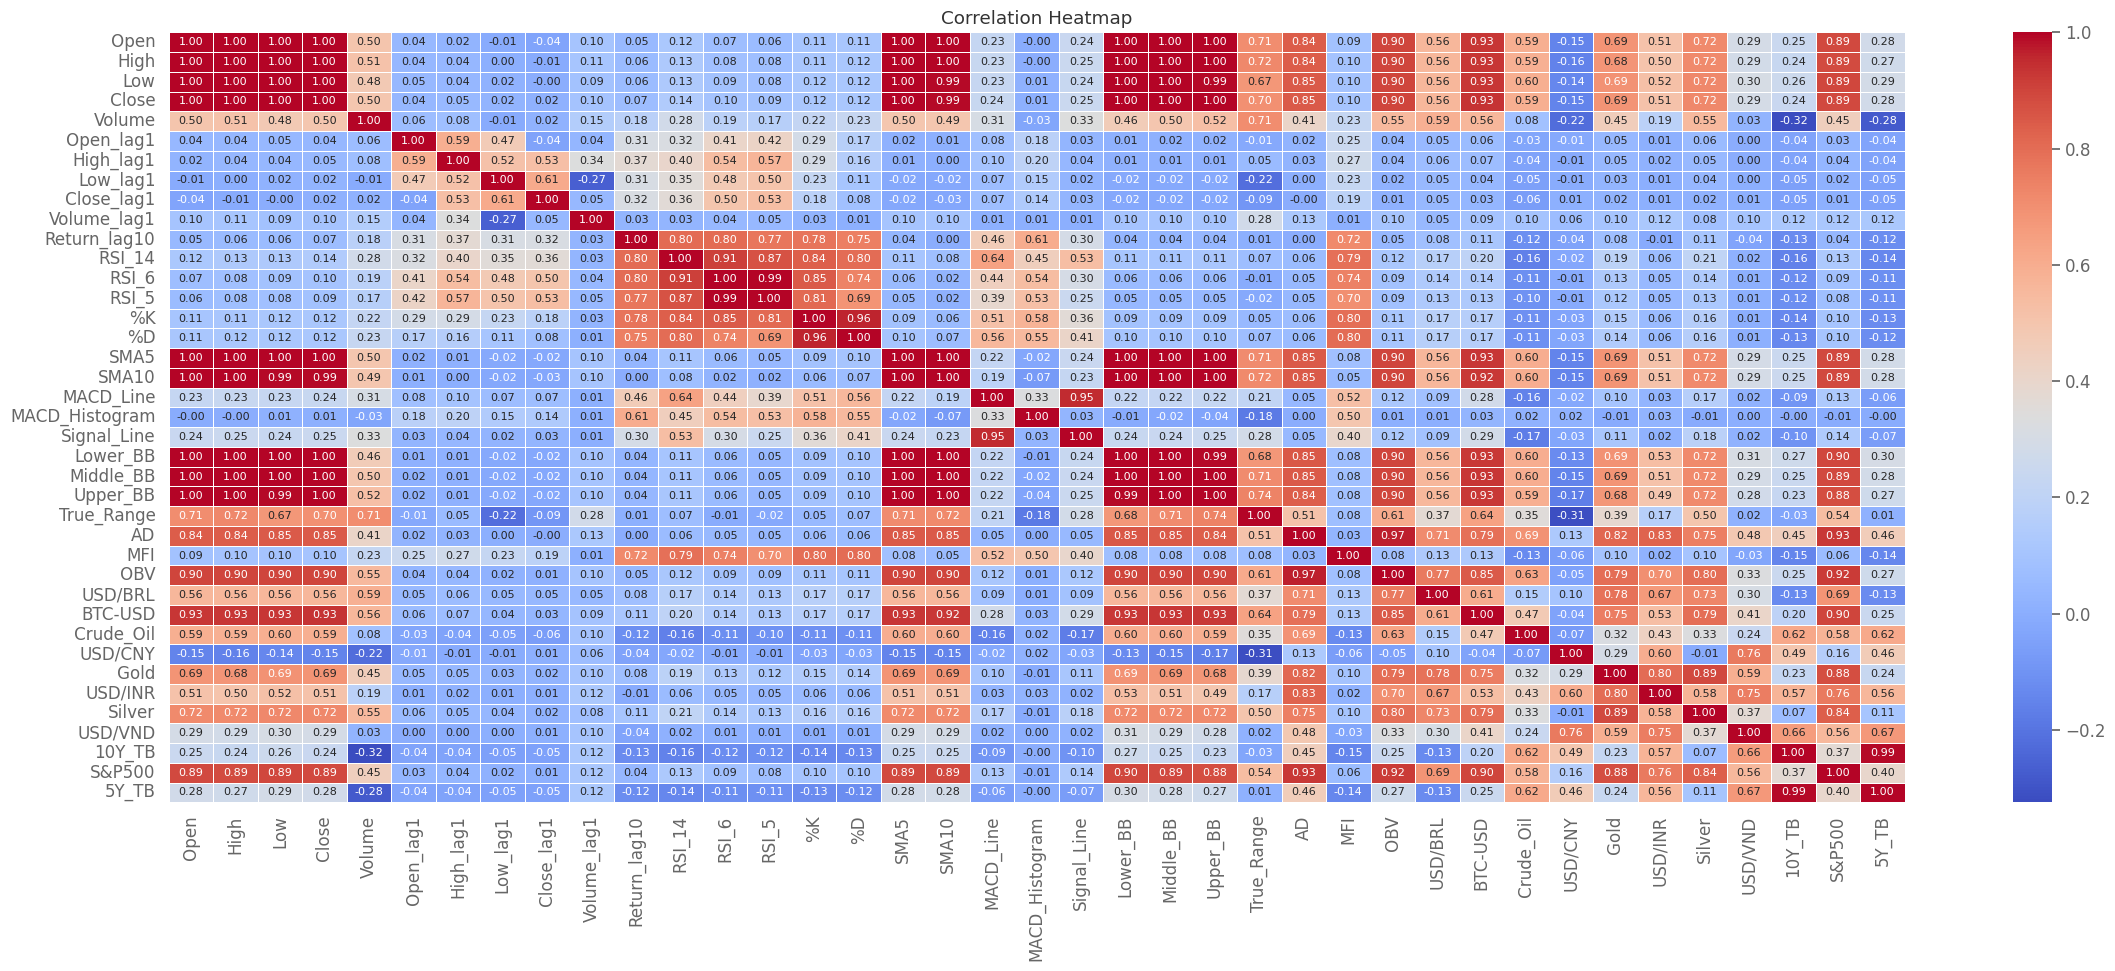

In [ ]:
# Plot technical indicators
plot_technical_indicators(eth_data, 1666)

plt.figure(figsize=(28, 10))
heatmap = sns.heatmap(eth_data.corr(), annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, annot_kws={"size": 8})
heatmap.set_title('Correlation Heatmap');

High Correlation with Close:


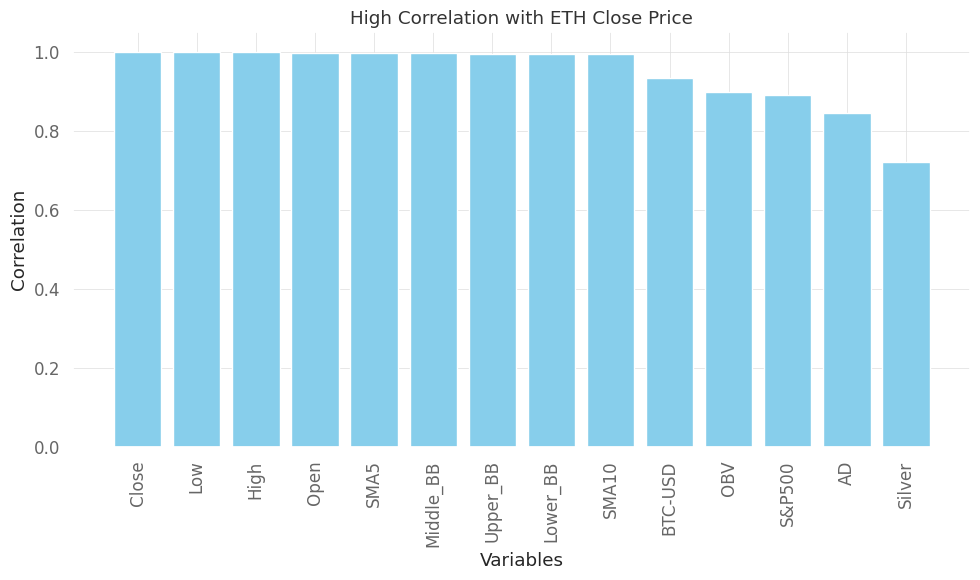

In [ ]:
high_correlation_df = high_correlation(eth_data, 'Close', threshold=0.7)

# Plot the high correlation variables with 'Close' using a bar plot
plt.bar(high_correlation_df.index, high_correlation_df, color='skyblue')
plt.title('High Correlation with ETH Close Price')
plt.ylabel('Correlation')
plt.xlabel('Variables')
plt.xticks(rotation=90)

# Save the plot as an image
plt.tight_layout()
plt.savefig('high_correlation_barplot.png', dpi=300)
plt.show()

## 2b. Feature Selection: XGBRegressor

In [ ]:
# Load the data
target_column = 'Close'
X_xgboost = eth_data.loc[:, eth_data.columns != target_column]
y_xgboost = eth_data[target_column].values

# Splitting
X_train_xgboost, X_test_xgboost, y_train_xgboost, y_test_xgboost = train_test_split(X_xgboost, y_xgboost, test_size = DATA_SPLIT_PCT, shuffle = False)

# Scale the data
scaler_xgboost = MinMaxScaler(feature_range=(0, 1))
X_train_scaled_xgboost = scaler_xgboost.fit_transform(X_train_xgboost)
X_test_scaled_xgboost = scaler_xgboost.transform(X_test_xgboost)

# Define the objective function
def objective(params):
    # Create XGBoost model with hyperparameters
    model = xg.XGBRegressor(
        objective='reg:squarederror',
        max_depth=int(params['max_depth']),
        n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        reg_lambda=params['reg_lambda'],
        reg_alpha=params['reg_alpha'],
        random_state=SEED
    )

    # Train the model
    model.fit(X_train_scaled_xgboost, y_train_xgboost)

    # Make predictions
    predictions = model.predict(X_test_scaled_xgboost)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test_xgboost, predictions))

    return {'loss': rmse, 'status': STATUS_OK}

# Define the hyperparameter space
space = {
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'n_estimators': hp.quniform('n_estimators', 50, 1000, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1)
}

# Create Trials object to store results
trials = Trials()

# Run Bayesian optimization
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,  # Number of iterations
    trials=trials
)

print("Best hyperparameters:", best)

100%|██████████| 100/100 [06:40<00:00,  4.01s/trial, best loss: 32.388761785229384]
Best hyperparameters: {'learning_rate': 0.13948462913832235, 'max_depth': 5.0, 'n_estimators': 352.0, 'reg_alpha': 0.7213086295534613, 'reg_lambda': 0.33842752395852405}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.13948462913832235,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=352, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...)

In [ ]:
# Apply best parameters to train final model
best_params = {
    'max_depth': int(best['max_depth']),
    'n_estimators': int(best['n_estimators']),
    'learning_rate': best['learning_rate'],
    'reg_lambda': best['reg_lambda'],
    'reg_alpha': best['reg_alpha']}

# Create final XGBoost model with best hyperparameters
final_model = xg.XGBRegressor(
    objective='reg:squarederror',
    **best_params,
    random_state=SEED
)

# Train the model
final_model.fit(X_train_scaled_xgboost, y_train_xgboost)

In [ ]:
# Save the model
#final_model.save_model('XGBRegressor_ETH.json')

# Upload the saved model
final_model = xg.XGBRegressor()
final_model.load_model('XGBRegressor_ETH.json')

In [ ]:
# Prediction
y_pred_xgboost = final_model.predict(X_test_scaled_xgboost)
predictions = [round(value) for value in y_pred_xgboost]

# RMSE computation
rmse = np.sqrt(mean_squared_error(y_test_xgboost, predictions))
print("RMSE: % f" %(rmse))

rmses = []
num_features = []

# Fit model using each importancce as a threshold
thresholds = sort(final_model.feature_importances_)
for thresh in thresholds:
  selection = SelectFromModel(final_model, threshold=thresh, prefit = True)
  select_X_train = selection.transform(X_train_scaled_xgboost)

  # train model
  selection_model = xg.XGBRegressor(
    objective='reg:squarederror',
    **best_params,
    random_state=SEED)
  selection_model.fit(select_X_train, y_train_xgboost)

  # evaluate model
  select_X_test = selection.transform(X_test_scaled_xgboost)
  predictions = selection_model.predict(select_X_test)
  rmse = np.sqrt(mean_squared_error(y_test_xgboost, predictions))
  rmses.append(rmse)
  num_features.append(select_X_train.shape[1])
  print("Thresh=%.3f, n=%d, RMSE: %f" %(thresh, select_X_train.shape[1], rmse))

RMSE:  32.375700
Thresh=0.000, n=38, RMSE: 32.388762
Thresh=0.000, n=37, RMSE: 32.388762
Thresh=0.000, n=36, RMSE: 33.138702
Thresh=0.000, n=35, RMSE: 33.184678
Thresh=0.000, n=34, RMSE: 32.395994
Thresh=0.000, n=33, RMSE: 33.407073
Thresh=0.000, n=32, RMSE: 33.776180
Thresh=0.000, n=31, RMSE: 32.955452
Thresh=0.000, n=30, RMSE: 31.935196
Thresh=0.000, n=29, RMSE: 32.220959
Thresh=0.000, n=28, RMSE: 32.793210
Thresh=0.000, n=27, RMSE: 33.407184
Thresh=0.000, n=26, RMSE: 32.046313
Thresh=0.000, n=25, RMSE: 33.407983
Thresh=0.000, n=24, RMSE: 33.461065
Thresh=0.000, n=23, RMSE: 32.690314
Thresh=0.000, n=22, RMSE: 34.307028
Thresh=0.000, n=21, RMSE: 35.915228
Thresh=0.000, n=20, RMSE: 35.516762
Thresh=0.000, n=19, RMSE: 35.012739
Thresh=0.000, n=18, RMSE: 34.820943
Thresh=0.000, n=17, RMSE: 34.050913
Thresh=0.000, n=16, RMSE: 34.900248
Thresh=0.000, n=15, RMSE: 34.149134
Thresh=0.000, n=14, RMSE: 35.675217
Thresh=0.000, n=13, RMSE: 32.648476
Thresh=0.000, n=12, RMSE: 33.338867
Thresh=0.00

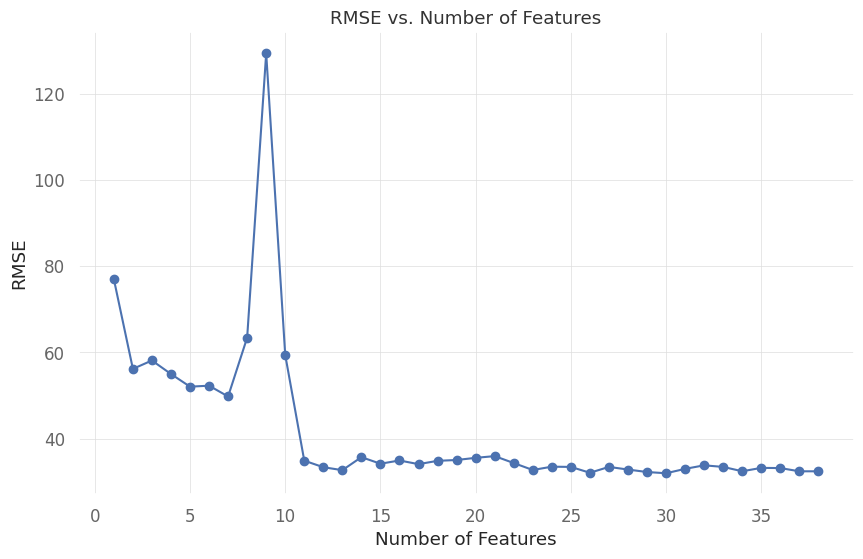

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(num_features, rmses, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('RMSE')
plt.title('RMSE vs. Number of Features')
plt.show()

In [ ]:
# Feature Importance
feature_importance_df = pd.DataFrame(final_model.feature_importances_, columns=['Importance'])
feature_importance_df['Feature'] = X_xgboost.columns

# Sort the DataFrame by 'Importance' in descending order
feature_importance_df.sort_values(by='Importance', ascending=True, inplace=True)
feature_importance_df

Importance         Feature
21    0.000000       Middle_BB
25    0.000002             MFI
35    0.000004          10Y_TB
3     0.000004          Volume
8     0.000004     Volume_lag1
32    0.000004         USD/INR
13    0.000005              %K
4     0.000005       Open_lag1
37    0.000005           5Y_TB
27    0.000005         USD/BRL
14    0.000006              %D
31    0.000006            Gold
5     0.000007       High_lag1
34    0.000008         USD/VND
29    0.000008       Crude_Oil
30    0.000008         USD/CNY
6     0.000008        Low_lag1
17    0.000008       MACD_Line
9     0.000010    Return_lag10
10    0.000011          RSI_14
18    0.000012  MACD_Histogram
19    0.000014     Signal_Line
23    0.000015      True_Range
11    0.000021           RSI_6
33    0.000029          Silver
24    0.000036              AD
12    0.000043           RSI_5
7     0.000223      Close_lag1
26    0.000257             OBV
36    0.000291          S&P500
28    0.000299         BTC-USD
0     0.000829            Open
16    0.001927           SMA10
20    0.001984        Lower_BB
15    0.003055            SMA5
22    0.006983        Upper_BB
1     0.481832            High
2     0.502032             Low



- We select the set of features with the lowest RMSE.



In [ ]:
column_to_select = ['Low', 'High', 'Upper_BB', 'SMA5', 'Lower_BB', 'SMA10', 'Open', 'BTC-USD', 'S&P500', 'OBV', 'Close_lag1', 'RSI_5', 'AD', 'Close']
eth_data_1 = eth_data[column_to_select].copy()
eth_data_1 = eth_data_1.dropna()
eth_data_1.tail()

Low         High     Upper_BB         SMA5     Lower_BB  \
Date                                                                          
2024-07-26  3172.777100  3285.760986  3564.106321  3341.826758  3119.547195   
2024-07-29  3257.715576  3396.625732  3353.944391  3257.998096  3162.051801   
2024-07-30  3235.760010  3365.322510  3325.980430  3278.846191  3231.711953   
2024-07-31  3216.071777  3347.636475  3330.781398  3269.915039  3209.048681   
2024-08-01  3078.543945  3241.777344  3342.589614  3260.706348  3178.823081   

                  SMA10         Open       BTC-USD       S&P500           OBV  \
Date                                                                            
2024-07-26  3408.578052  3174.051025  67912.062500  5459.100098  1.438845e+12   
2024-07-29  3360.464648  3271.453369  66819.914062  5463.540039  1.450941e+12   
2024-07-30  3336.401880  3320.635254  66201.015625  5436.439941  1.436895e+12   
2024-07-31  3305.870898  3278.686523  64619.250000  5522.299805  1.420760e+12   
2024-08-01  3281.985352  3231.248779  65357.500000  5446.680176  1.400542e+12   

            Close_lag1      RSI_5            AD        Close  
Date                                                          
2024-07-26    0.031982  40.370992  2.845052e+12  3275.951416  
2024-07-29    0.015001  50.565544  2.846515e+12  3320.539307  
2024-07-30   -0.012610  43.585814  2.841772e+12  3278.667725  
2024-07-31   -0.014449  36.467147  2.829371e+12  3231.295654  
2024-08-01   -0.009201  32.325281  2.839627e+12  3201.564453

In [ ]:
eth_data_1.describe()

Low         High     Upper_BB         SMA5     Lower_BB  \
count  1666.000000  1666.000000  1666.000000  1666.000000  1666.000000   
mean   1374.751397  1464.689098  1510.065872  1420.146194  1330.226515   
std    1171.611631  1248.093579  1282.369103  1207.710874  1138.005911   
min      83.226479    87.144943    93.788877    87.136870    76.323355   
25%     236.848022   248.317261   259.839648   243.552622   229.348792   
50%    1234.057495  1302.685242  1348.618788  1275.693262  1189.735197   
75%    2088.732910  2260.904419  2319.167004  2202.249426  2020.596773   
max    4718.039062  4891.704590  4882.614260  4716.166016  4594.297104   

             SMA10         Open       BTC-USD       S&P500           OBV  \
count  1666.000000  1666.000000   1666.000000  1666.000000  1.666000e+03   
mean   1417.716580  1422.796372  25148.036633  3722.986825  7.896365e+11   
std    1205.308791  1212.735270  18975.044490   806.896220  6.358442e+11   
min      89.421030    85.382111   3242.484863  2237.399902 -3.970243e+10   
25%     242.458284   244.704353   8805.110840  2908.634949  5.083289e+10   
50%    1270.693658  1276.246033  19932.508789  3823.264893  1.118807e+12   
75%    2180.865790  2187.792236  39198.291016  4365.907471  1.340103e+12   
max    4655.828906  4810.071289  73083.500000  5667.200195  1.789614e+12   

        Close_lag1        RSI_5            AD        Close  
count  1666.000000  1666.000000  1.666000e+03  1666.000000  
mean      0.001167    51.478536  1.413972e+12  1422.142217  
std       0.049345    20.876843  1.134904e+12  1211.092778  
min      -0.423472     2.950716  9.856736e+09    84.308296  
25%      -0.022031    36.419978  1.511199e+11   244.937771  
50%      -0.000205    50.336886  1.710469e+12  1273.909485  
75%       0.024947    66.678413  2.505308e+12  2174.951599  
max       0.264581    97.362912  2.862261e+12  4812.087402

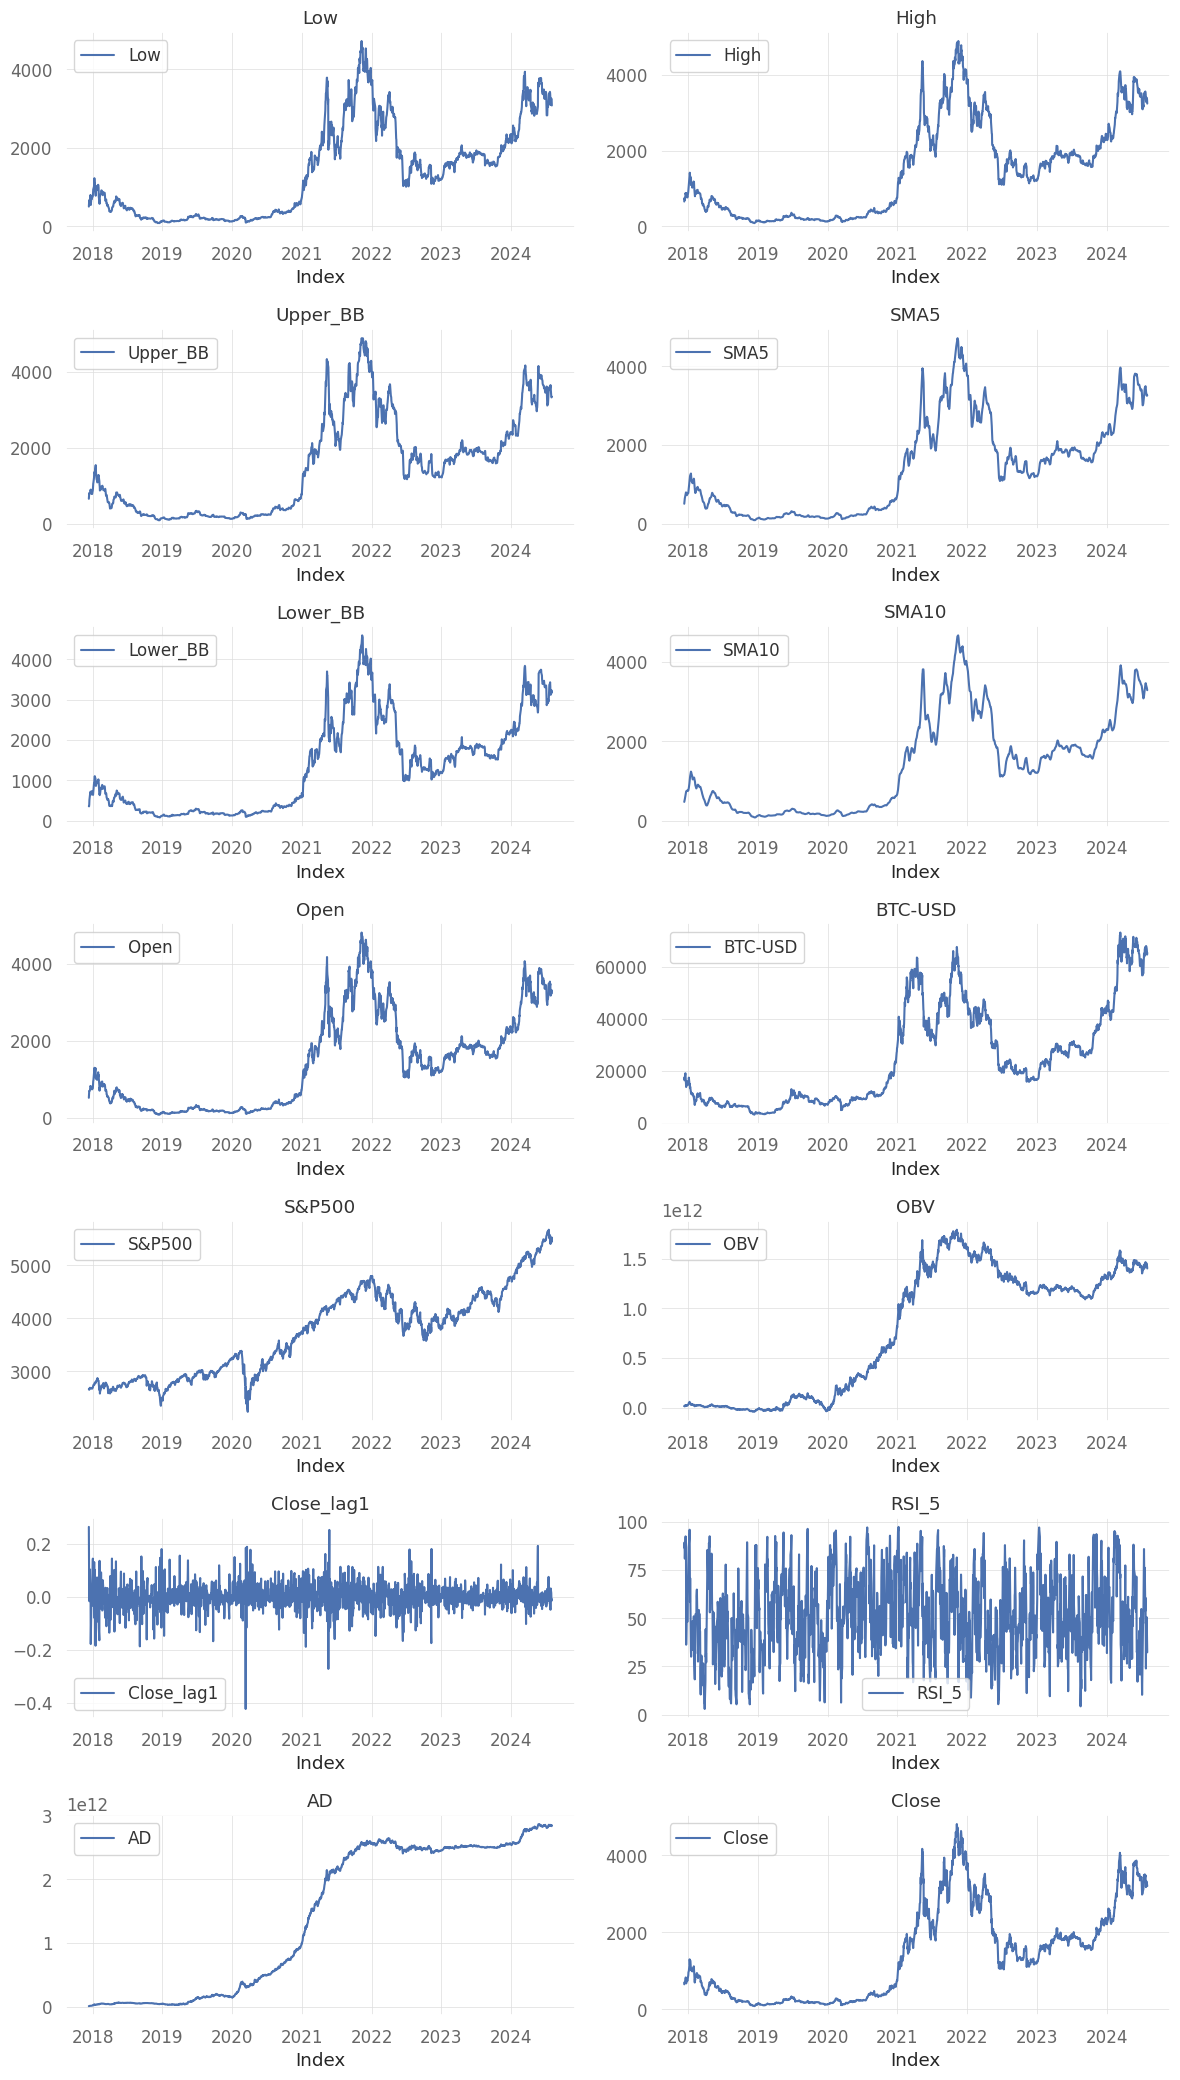

In [ ]:
# Visualization
df_to_plot = eth_data_1[column_to_select].copy()
plot_columns(df_to_plot)

## 2c. Data Temporalization, Data Splitting and Data Scaling

In [ ]:
# Temporalizing the Data: samples x lookback x features
target_column = 'Close'
lookback = 5

# Extract the features and target
input_X, input_y, n_features = input(eth_data_1, target_column)
n_features = input_X.shape[1]

# Temporalize the data
X, y = temporalize(X = input_X, y = input_y, lookback = lookback)
print('The shape of X:', X.shape)
print('The shape of y:', y.shape)

# Split into train, valid, and test
X_train, X_test, X_valid, y_train, y_test, y_valid = split_data(X, y, DATA_SPLIT_PCT, SEED)

# Reshape
X_train = X_train.reshape(X_train.shape[0], lookback, n_features)
X_valid = X_valid.reshape(X_valid.shape[0], lookback, n_features)
X_test = X_test.reshape(X_test.shape[0], lookback, n_features)
TIMESTEPS = X_train.shape[1] # equal to the lookback

print('The shape of train data:', X_train.shape, y_train.shape)
print('The shape of valid data:', X_valid.shape, y_valid.shape)
print('The shape of test data:', X_test.shape, y_test.shape)
print('Lookback:', TIMESTEPS)
print('Number of features:', n_features)

# Scale the training data.
scaler_X = MinMaxScaler(feature_range=(0, 1)).fit(flatten(X_train))
X_train_scaled = scale(X_train, scaler_X)
X_valid_scaled = scale(X_valid, scaler_X)
X_test_scaled = scale(X_test, scaler_X)

The shape of X: (1660, 5, 13)
The shape of y: (1660,)
The shape of train data: (1062, 5, 13) (1062,)
The shape of valid data: (266, 5, 13) (266,)
The shape of test data: (332, 5, 13) (332,)
Lookback: 5
Number of features: 13


**The sections 4 and 5 present how LSTM and BiLSTM models are trained. The best model performance is saved, then reloading to make future predictions. Similarly, the same process is applied to BiLSTM.**

# 4. BAYESIAN HYPER-PARAMETER TUNING LSTM MODEL



In [ ]:
# Define shape and output
input_shape = (X_train.shape[1], X_train.shape[2])
output_units = y_train.shape[1] if len(y_train.shape) > 1 else 1  # Adjust based on target shape

# Bayesian-LSTM
lstm_hypermodel = LSTMHyperModel(input_shape=input_shape, output_units=output_units)

# Fit the model
model_bayesian_lstm = bayesian_opt_tuner(lstm_hypermodel, X_train_scaled, y_train, X_valid_scaled, y_valid)
history_bayesian_lstm = fit_model(model_bayesian_lstm, X_train_scaled, y_train, X_valid_scaled, y_valid)

The best hyperparameters are 
 {'lstm_layer_1': 59, 'dropout_1': 0.2, 'lstm_layer_2': 79, 'dropout_2': 0.30000000000000004, 'learning_rate': 0.001}


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 5, 59)               │          17,228 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 5, 59)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 5, 79)               │          43,924 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 395)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 395)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │             396 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 61,548 (240.42 KB)

 Trainable params: 61,548 (240.42 KB)

 Non-trainable params: 0 (0.00 B)

None


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


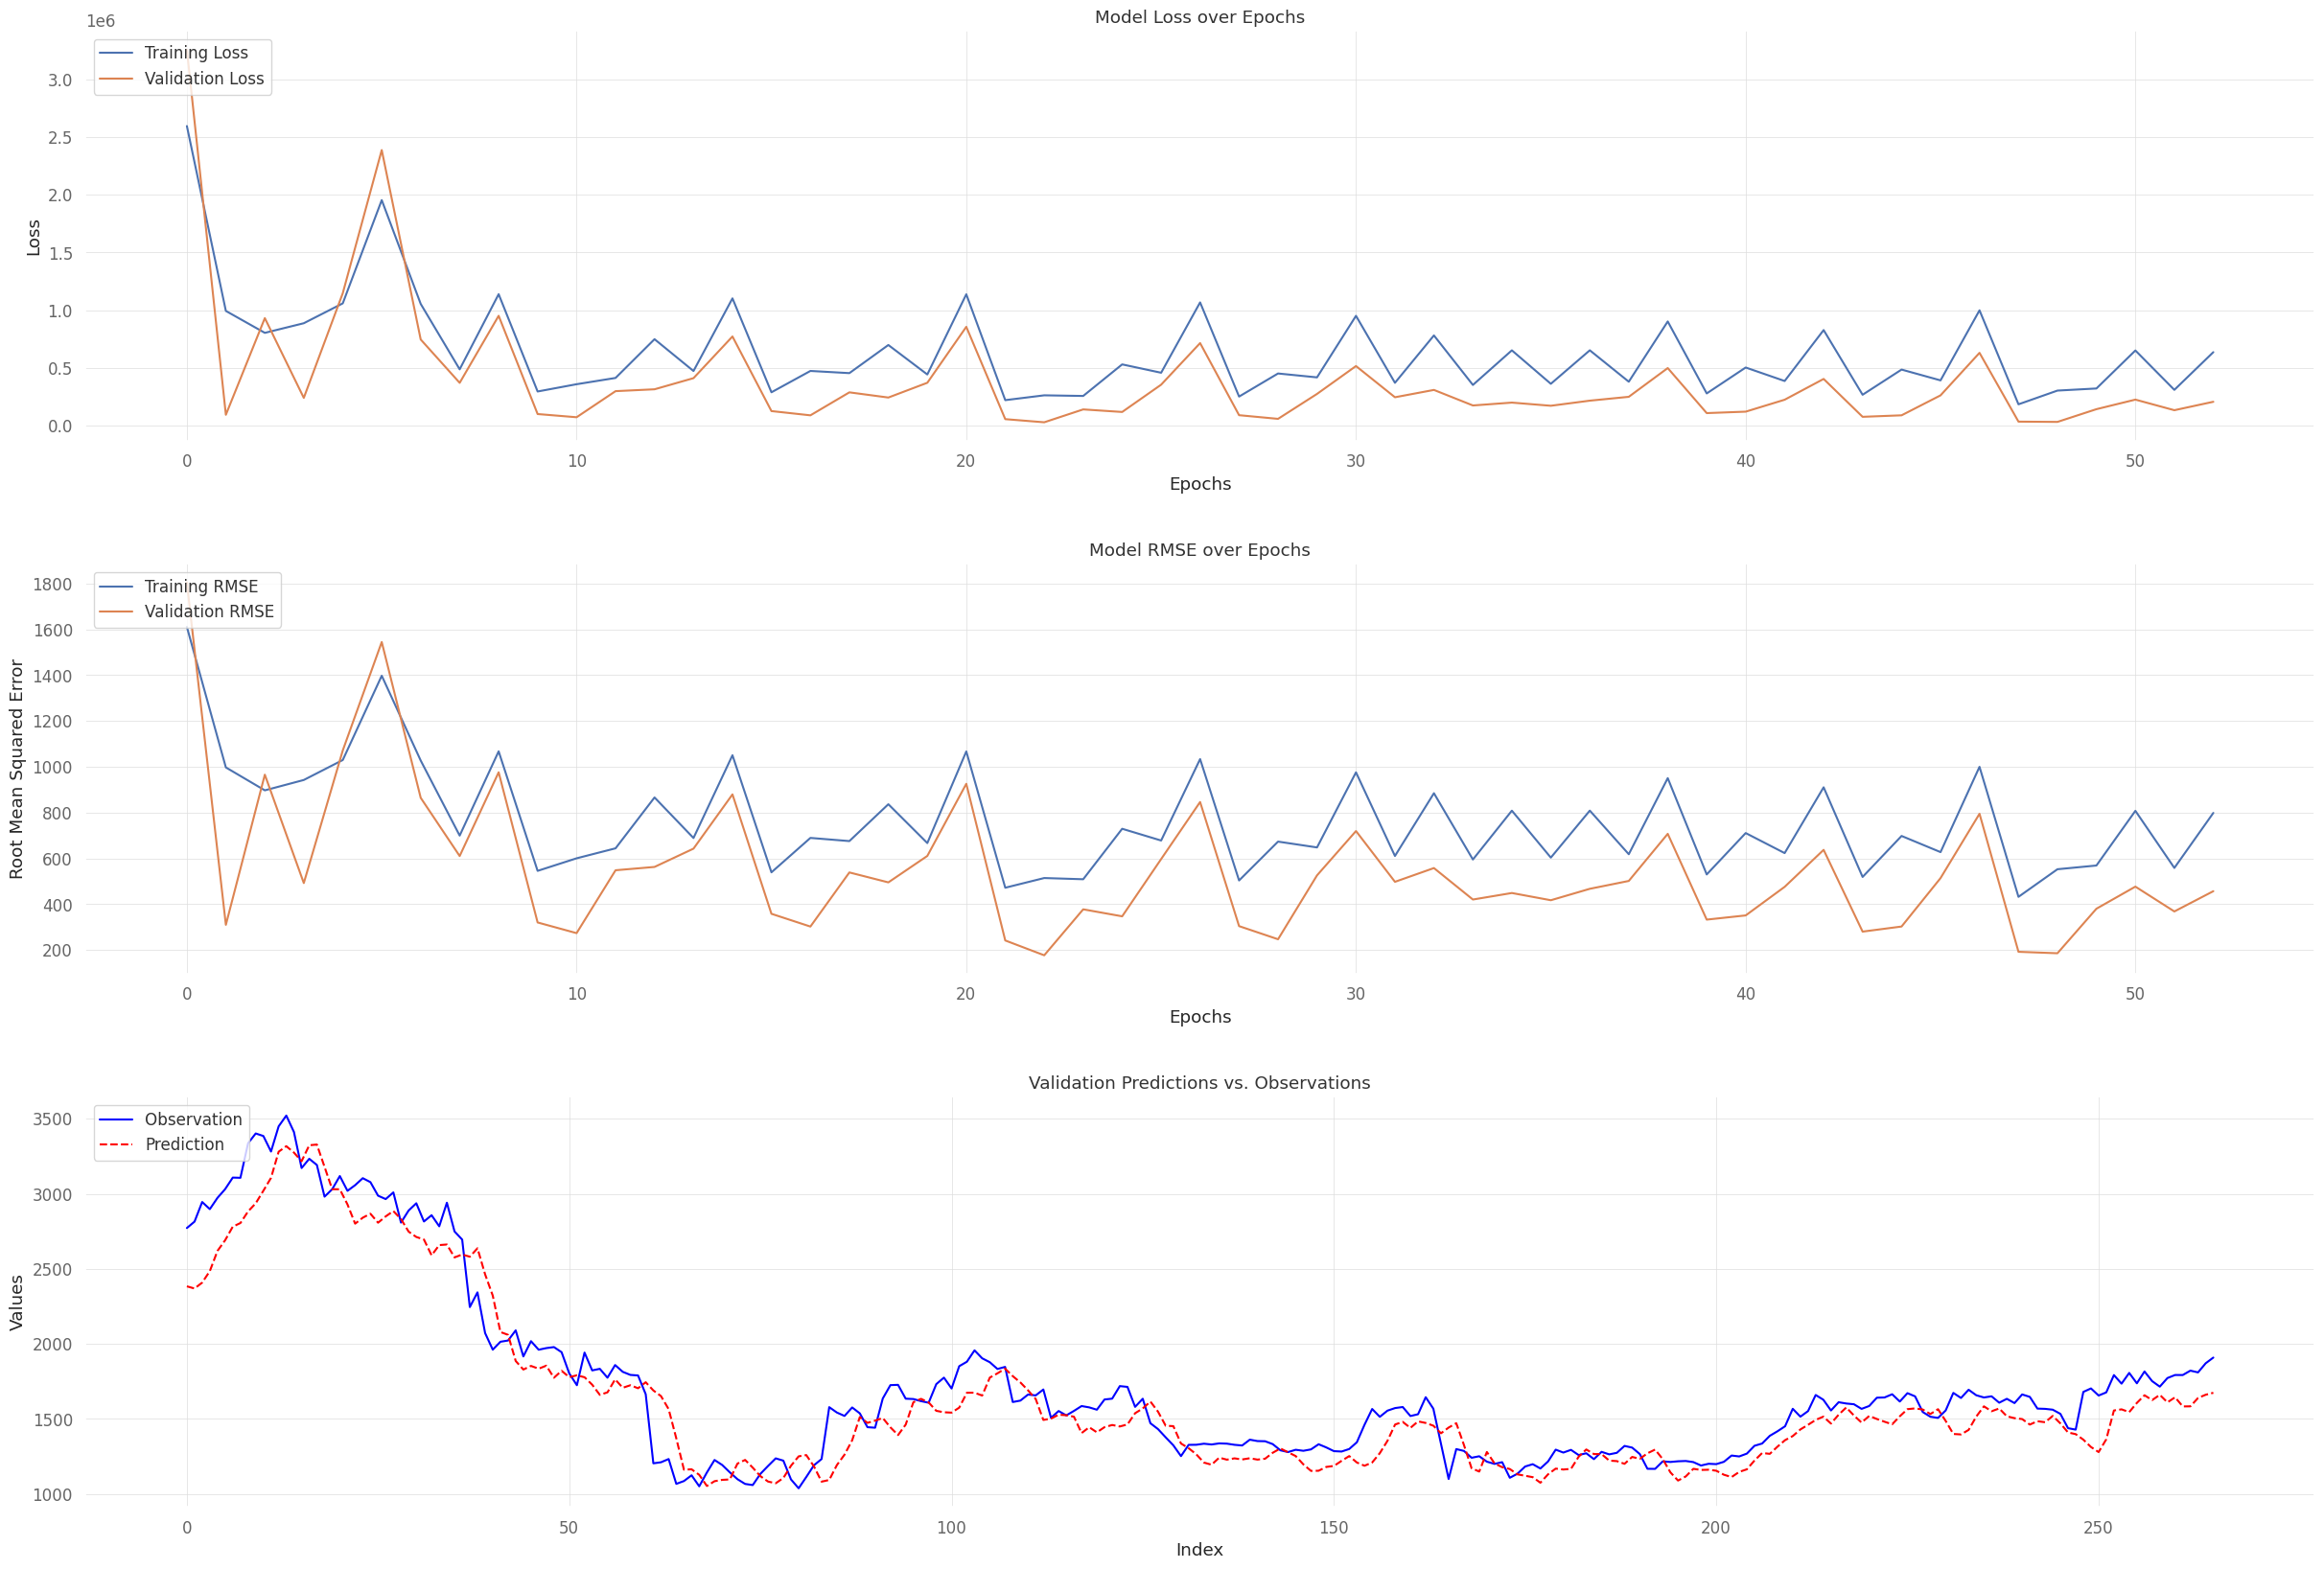

In [ ]:
# Inspect performance on validation data
val_inspection(history_bayesian_lstm, model_bayesian_lstm, X_valid_scaled, y_valid)

In [ ]:
# Step by step to reload the trained model
# Step 1: Save the trained model
model_bayesian_lstm.save('bayesian_lstm_ETH.keras')

# Step 2: Load the model
#model_bayesian_lstm = load_model('bayesian_lstm_ETH.keras')

# Step 3: Fit the model
#history_bayesian_lstm = fit_model(model_bayesian_lstm, X_train_scaled, y_train, X_valid_scaled, y_valid)

In [ ]:
# Check performance metrics
train_predict_bayesian_lstm = model_bayesian_lstm.predict(X_train_scaled)
valid_predict_bayesian_lstm = model_bayesian_lstm.predict(X_valid_scaled)
test_predict_bayesian_lstm = model_bayesian_lstm.predict(X_test_scaled)

bayesian_lstm_train_mae, bayesian_lstm_train_rmse = evaluate_prediction(train_predict_bayesian_lstm, y_train, 'Evaluation result from Bayesian-Hyperparameter Tuning LSTM on train data')
bayesian_lstm_valid_mae, bayesian_lstm_valid_rmse = evaluate_prediction(valid_predict_bayesian_lstm, y_valid, 'Evaluation result from Bayesian-Hyperparameter Tuning LSTM on valid data')
bayesian_lstm_test_mae, bayesian_lstm_test_rmse = evaluate_prediction(test_predict_bayesian_lstm, y_test, 'Evaluation result from Bayesian-Hyperparameter Tuning LSTM on test data')

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Evaluation result from Bayesian-Hyperparameter Tuning LSTM on train data:
Mean Absolute Error: 1152.7475
Root Mean Square Error: 1699.3832

Evaluation result from Bayesian-Hyperparameter Tuning LSTM on valid data:
Mean Absolute Error: 579.9918
Root Mean Square Error: 816.4150

Evaluation result from Bayesian-Hyperparameter Tuning LSTM on test data:
Mean Absolute Error: 860.1707
Root Mean Square Error: 1094.0943



11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Out-of-sample R-squared: 0.93
Bayesian-Hyperparameter Tuning LSTM:
Mean Absolute Error: 860.1707
Root Mean Square Error: 1094.0943



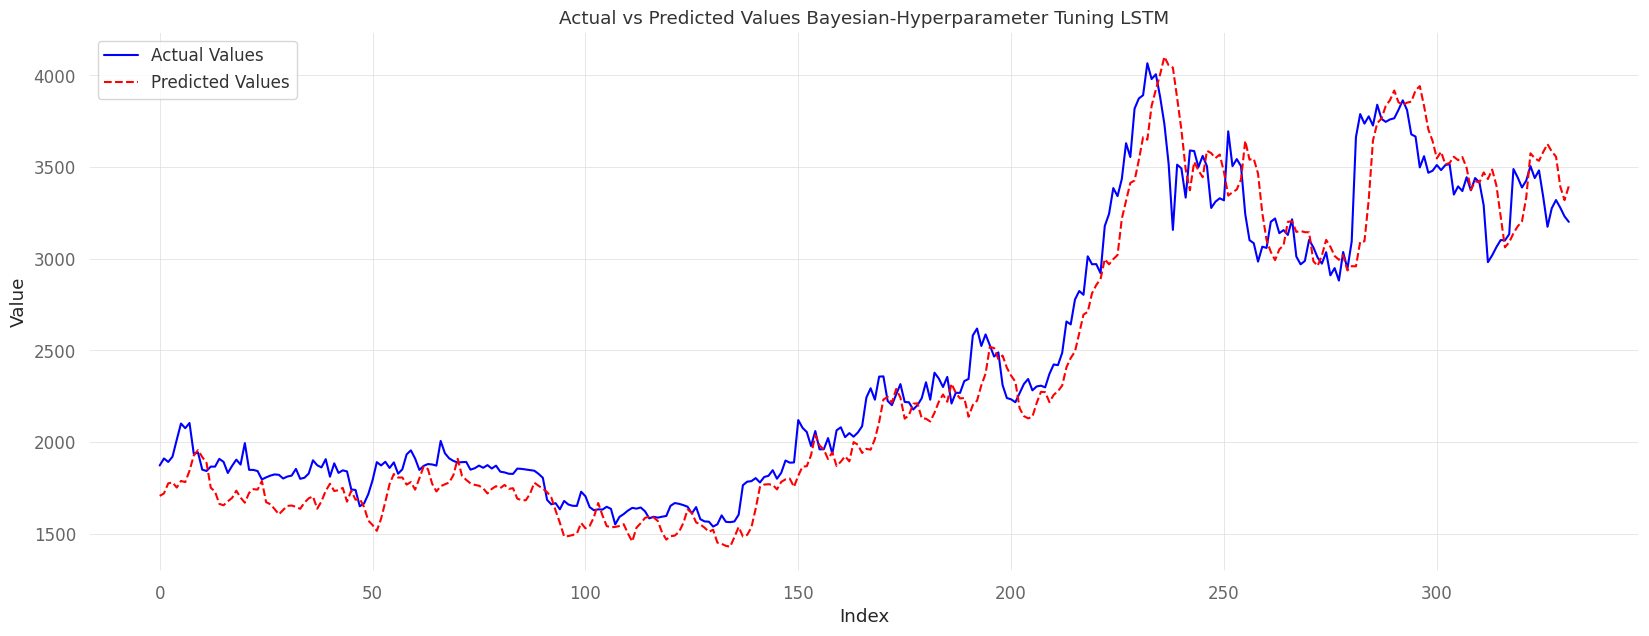

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


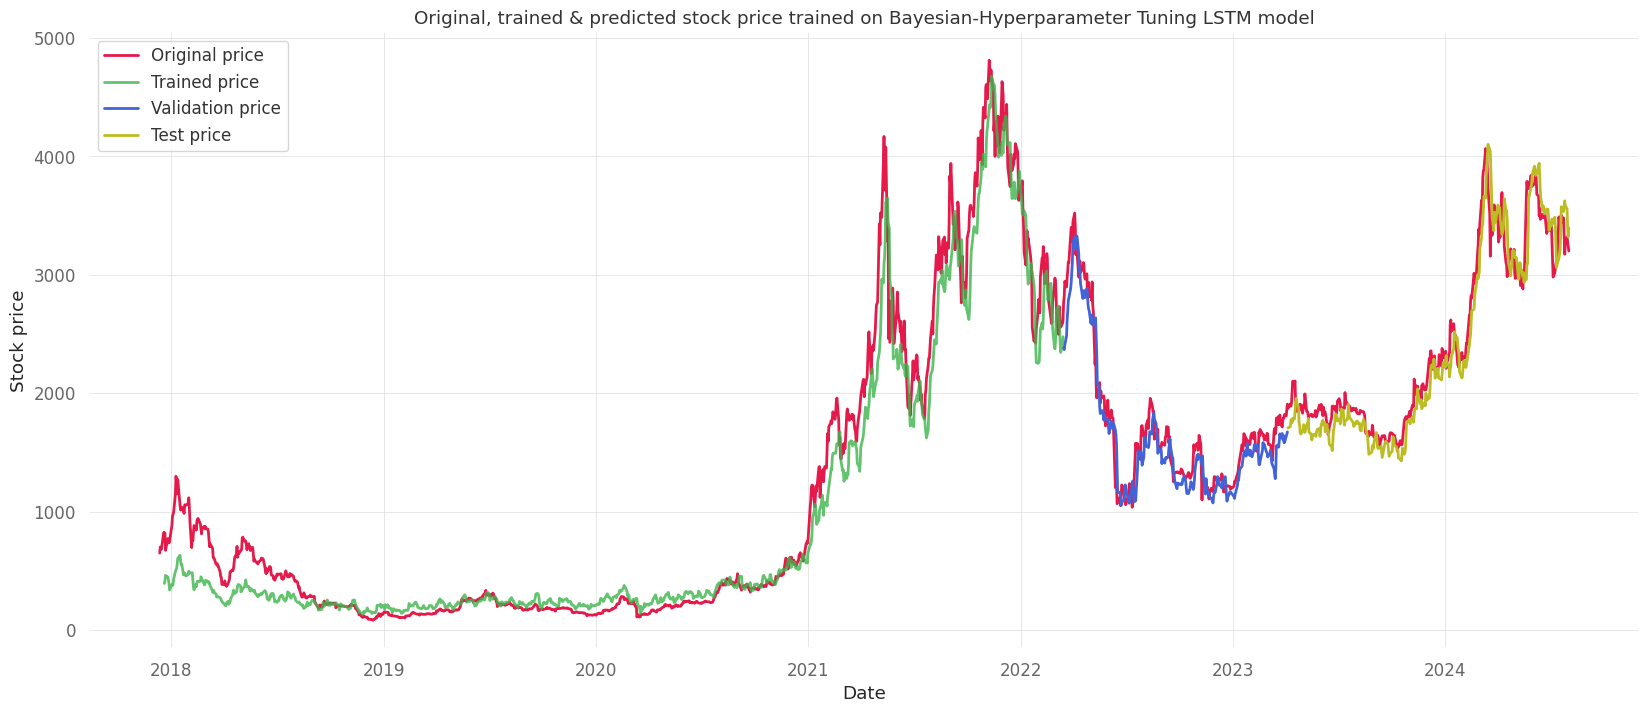

In [ ]:
# Inspect and visualize test performance
bayesian_lstm_predictions = test_inspection(model_bayesian_lstm, X_test_scaled, y_test, 'Bayesian-Hyperparameter Tuning LSTM')
prediction_bayesian_lstm_df = final_visualization(eth_data_1, lookback, DATA_SPLIT_PCT, SEED, model_bayesian_lstm, X_train_scaled, X_valid_scaled, bayesian_lstm_predictions, eth_data_1[target_column], 'Bayesian-Hyperparameter Tuning LSTM')

# 5. BAYESIAN HYPER-PARAMETER TUNING BILSTM MODEL

In [ ]:
# Instantiate the HyperModel
hypermodel_BILSTM = BILSTMHyperModel(input_shape=input_shape, output_units=output_units)

# Bayesian Optimization
bayesian_bilstm_model = bayesian_opt_tuner(hypermodel_BILSTM, X_train_scaled, y_train, X_valid_scaled, y_valid)
history_bayesian_bilstm = fit_model(bayesian_bilstm_model, X_train_scaled, y_train, X_valid_scaled, y_valid)

The best hyperparameters are 
 {'bi_lstm_layer_1': 11, 'dropout_1': 0.30000000000000004, 'bi_lstm_layer_2': 85, 'dropout_2': 0.4, 'learning_rate': 0.01}


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional)      │ (None, 5, 22)               │           2,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 5, 22)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 5, 170)              │          73,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 850)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 850)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │             851 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 76,491 (298.79 KB)

 Trainable params: 76,491 (298.79 KB)

 Non-trainable params: 0 (0.00 B)

None


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


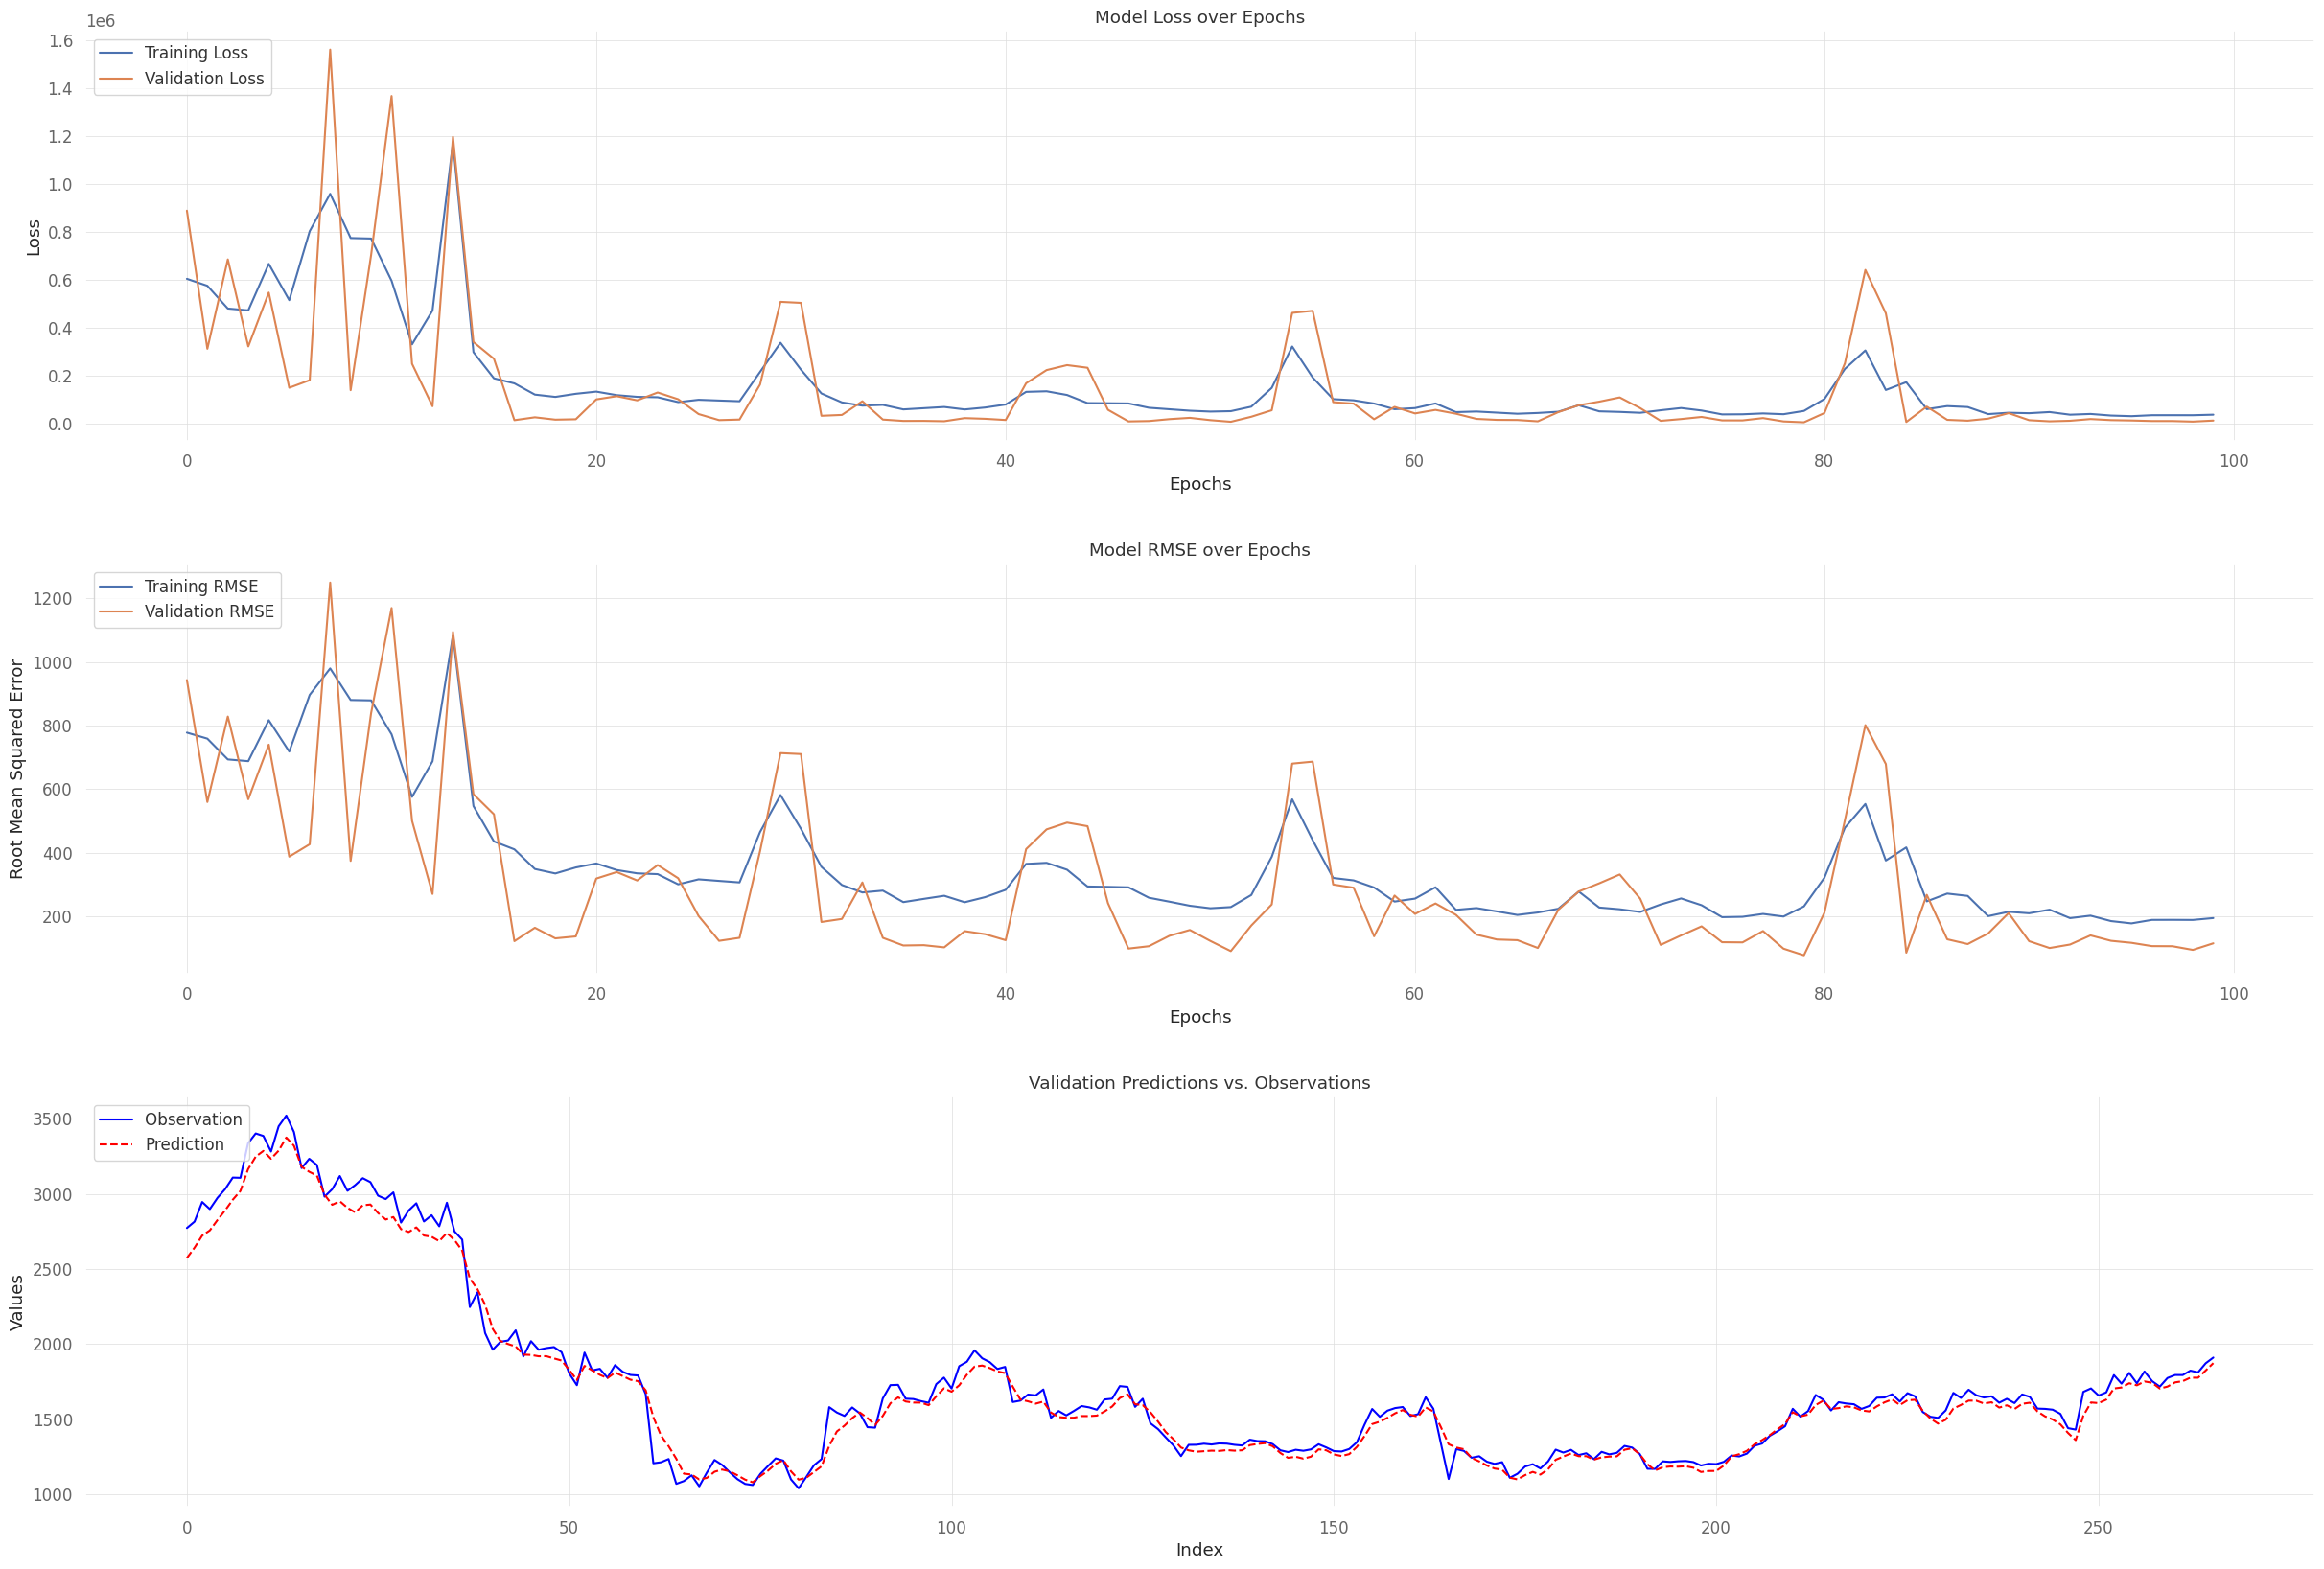

In [ ]:
# Inspect performance on validation data
val_inspection(history_bayesian_bilstm, bayesian_bilstm_model, X_valid_scaled, y_valid)

In [ ]:
# Step by step to reload the trained model
# Step 1: Save the trained model
bayesian_bilstm_model.save('bayesian_bilstm_model_ETH.keras')

# Step 2: Load the model
#bayesian_bilstm_model = load_model('bayesian_bilstm_model_ETH.keras')

# Step 3: Fit the model
#history_bayesian_bilstm = fit_model(bayesian_bilstm_model, X_train_scaled, y_train, X_valid_scaled, y_valid)

In [ ]:
# Check performance metrics
train_predict_bayesian_bilstm = bayesian_bilstm_model.predict(X_train_scaled)
valid_predict_bayesian_bilstm = bayesian_bilstm_model.predict(X_valid_scaled)
test_predict_bayesian_bilstm = bayesian_bilstm_model.predict(X_test_scaled)

bayesian_bilstm_train_mae, bayesian_bilstm_train_rmse= evaluate_prediction(train_predict_bayesian_bilstm, y_train, 'Evaluation result from Bayesian-Hyperparameter Tuning BILSTM on train data')
bayesian_bilstm_valid_mae, bayesian_bilstm_valid_rmse = evaluate_prediction(valid_predict_bayesian_bilstm, y_valid, 'Evaluation result from Bayesian-Hyperparameter Tuning BILSTM on valid data')
bayesian_bilstm_test_mae, bayesian_bilstm_test_rmse = evaluate_prediction(test_predict_bayesian_bilstm, y_test, 'Evaluation result from Bayesian-Hyperparameter Tuning BILSTM on test data')

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Evaluation result from Bayesian-Hyperparameter Tuning BILSTM on train data:
Mean Absolute Error: 1198.5291
Root Mean Square Error: 1739.5475

Evaluation result from Bayesian-Hyperparameter Tuning BILSTM on valid data:
Mean Absolute Error: 579.2115
Root Mean Square Error: 814.4006

Evaluation result from Bayesian-Hyperparameter Tuning BILSTM on test data:
Mean Absolute Error: 808.6823
Root Mean Square Error: 1029.4532



11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Out-of-sample R-squared: 0.98
Bayesian-Hyperparameter Tuning BILSTM:
Mean Absolute Error: 808.6823
Root Mean Square Error: 1029.4532



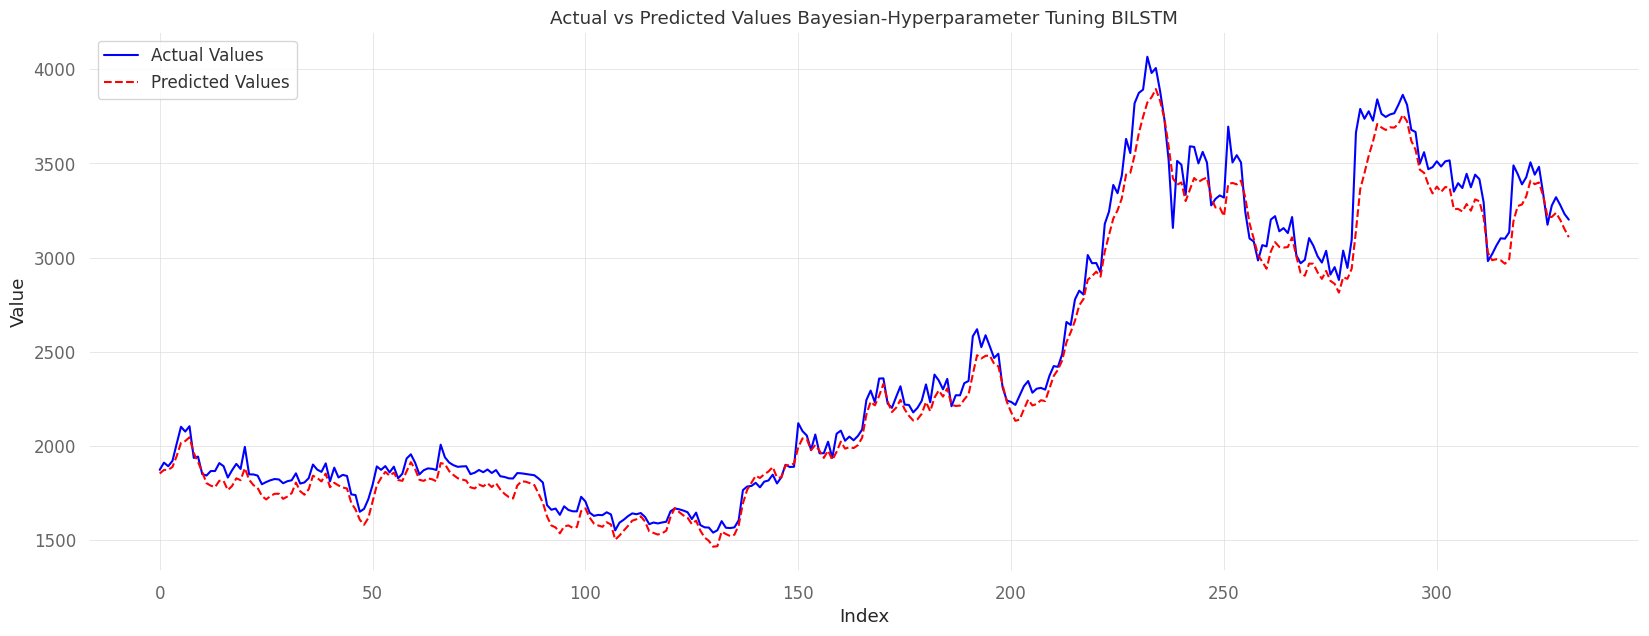

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


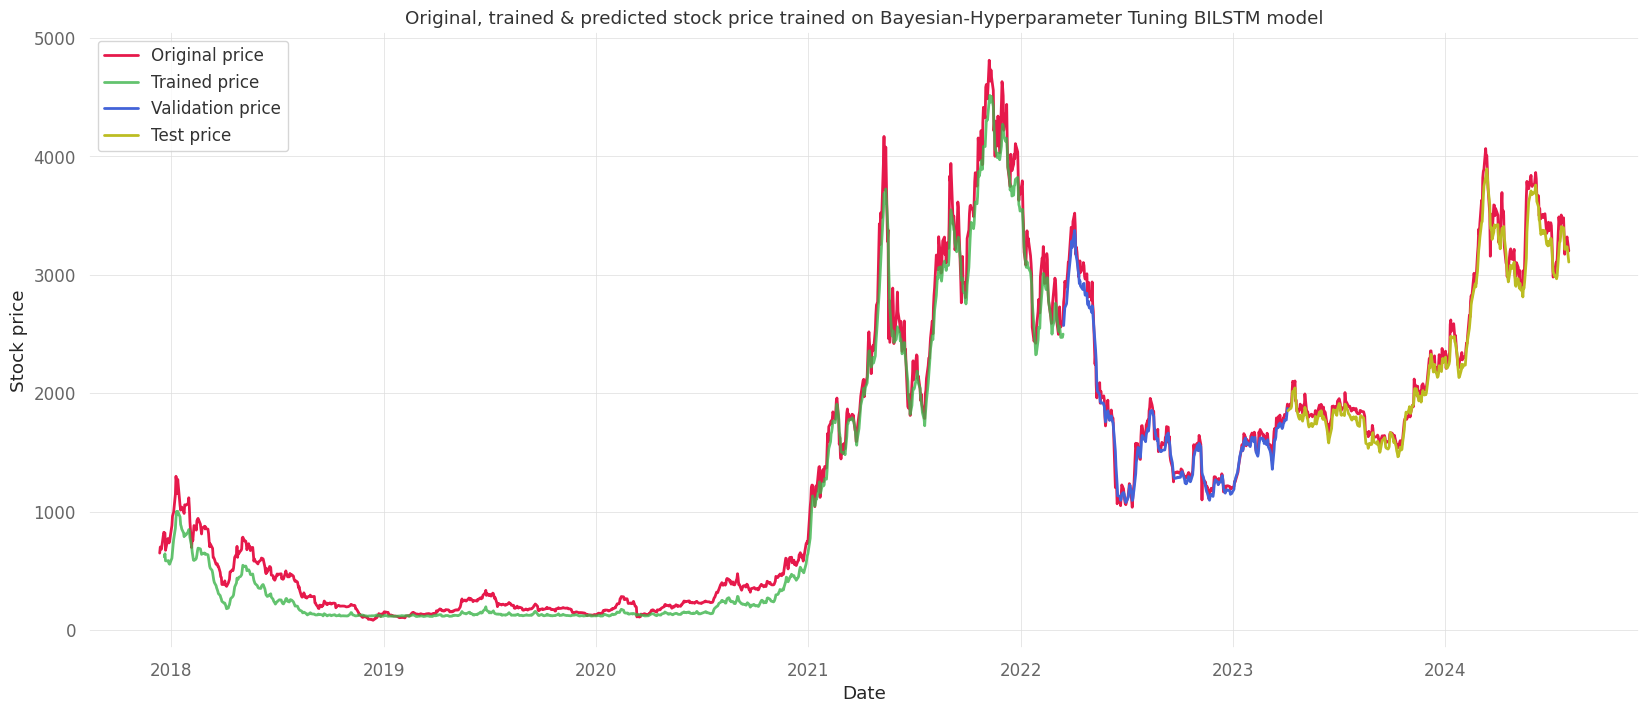

In [ ]:
# Inspect and visualize test performance
bayesian_bilstm_predictions = test_inspection(bayesian_bilstm_model, X_test_scaled, y_test, 'Bayesian-Hyperparameter Tuning BILSTM')
prediction_bayesian_bilstm_df = final_visualization(eth_data_1, lookback, DATA_SPLIT_PCT, SEED, bayesian_bilstm_model, X_train_scaled, X_valid_scaled, bayesian_bilstm_predictions, eth_data_1[target_column], 'Bayesian-Hyperparameter Tuning BILSTM')

# 6. RESULT - LSTM & BILSTM

In [ ]:
# Define model names
model_names = ['Bayesian_LSTM', 'Bayesian_BILSTM']

# Create a dictionary to store the results
results_dict = {
    'Train_MAE': [bayesian_lstm_train_mae, bayesian_bilstm_train_mae],
    'Train_RMSE': [bayesian_lstm_train_rmse, bayesian_bilstm_train_rmse],
    'Valid_MAE': [bayesian_lstm_valid_rmse, bayesian_bilstm_valid_mae],
    'Valid_RMSE': [bayesian_lstm_valid_rmse, bayesian_bilstm_valid_rmse],
    'Test_MAE': [bayesian_lstm_test_mae, bayesian_bilstm_test_mae],
    'Test_RMSE': [ bayesian_lstm_test_rmse, bayesian_bilstm_test_rmse],
    'R2-OOS': [0.93, 0.98]
}

# Display result
results_df = pd.DataFrame(results_dict, index=model_names)
results_df

Train_MAE   Train_RMSE   Valid_MAE  Valid_RMSE    Test_MAE  \
Bayesian_LSTM    1152.747508  1699.383244  816.414985  816.414985  860.170668   
Bayesian_BILSTM  1198.529136  1739.547492  579.211455  814.400628  808.682281   

                   Test_RMSE  R2-OOS  
Bayesian_LSTM    1094.094318    0.93  
Bayesian_BILSTM  1029.453196    0.98

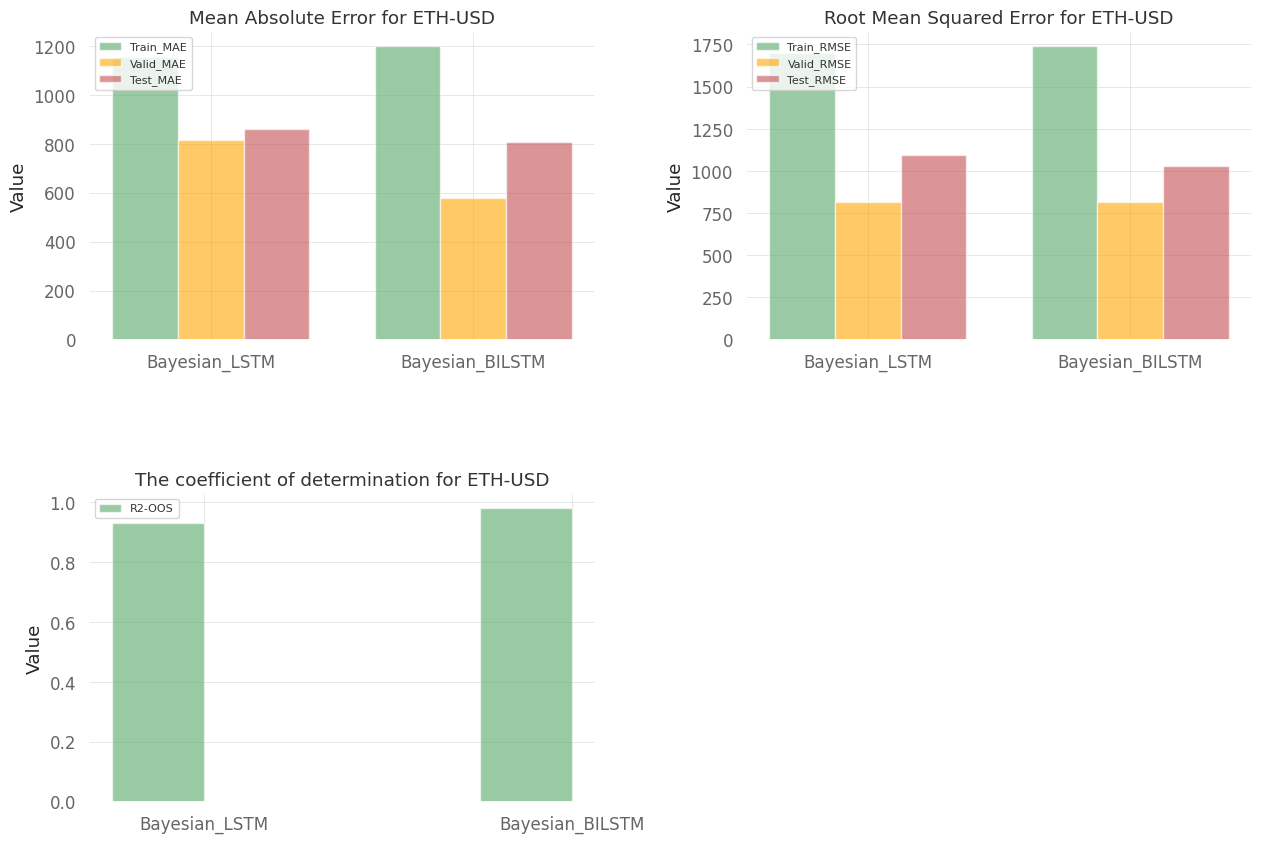

In [ ]:
stock = 'ETH-USD'
x = np.arange(len(results_df))  # Get the positions for the bars
bar_width = 0.25  # Set the width of the bars

fig, axes = plt.subplots(2, 2, figsize=(15,10))  # Create a 2x2 grid for subplots

# Plot first subplot (MAE)
axes[0, 0].bar(x - bar_width, results_df['Train_MAE'], width=bar_width, label='Train_MAE', color='g', alpha=0.6)
axes[0, 0].bar(x, results_df['Valid_MAE'], width=bar_width, label='Valid_MAE', color='orange', alpha=0.6)
axes[0, 0].bar(x + bar_width, results_df['Test_MAE'], width=bar_width, label='Test_MAE', color='r', alpha=0.6)
axes[0, 0].set_title('Mean Absolute Error for {}'.format(stock))
axes[0, 0].set_ylabel('Value')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(results_df.index)
axes[0, 0].legend(loc='upper left', fontsize=8)

# Plot second subplot (RMSE)
axes[0, 1].bar(x - bar_width, results_df['Train_RMSE'], width=bar_width, label='Train_RMSE', color='g', alpha=0.6)
axes[0, 1].bar(x, results_df['Valid_RMSE'], width=bar_width, label='Valid_RMSE', color='orange', alpha=0.6)
axes[0, 1].bar(x + bar_width, results_df['Test_RMSE'], width=bar_width, label='Test_RMSE', color='r', alpha=0.6)
axes[0, 1].set_title('Root Mean Squared Error for {}'.format(stock))
axes[0, 1].set_ylabel('Value')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(results_df.index)
axes[0, 1].legend(loc='upper left', fontsize=8)

# Plot third subplot (R2-OOS)
axes[1, 0].bar(x - bar_width / 2, results_df['R2-OOS'], width=bar_width, label='R2-OOS', color='g', alpha=0.6)
axes[1, 0].set_title('The coefficient of determination for {}'.format(stock))
axes[1, 0].set_ylabel('Value')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(results_df.index)
axes[1, 0].legend(loc='upper left', fontsize=8)

# Remove the fourth subplot (empty)
fig.delaxes(axes[1, 1])  # Remove the last (empty) plot

# Adjust layout
plt.subplots_adjust(hspace=0.5, wspace=0.3)  # Adjust the spacing between plots
plt.savefig('result_eth.png', dpi=300)
plt.show()

# 7. DISUSSION - STRATEGY vs. BENCHMARK



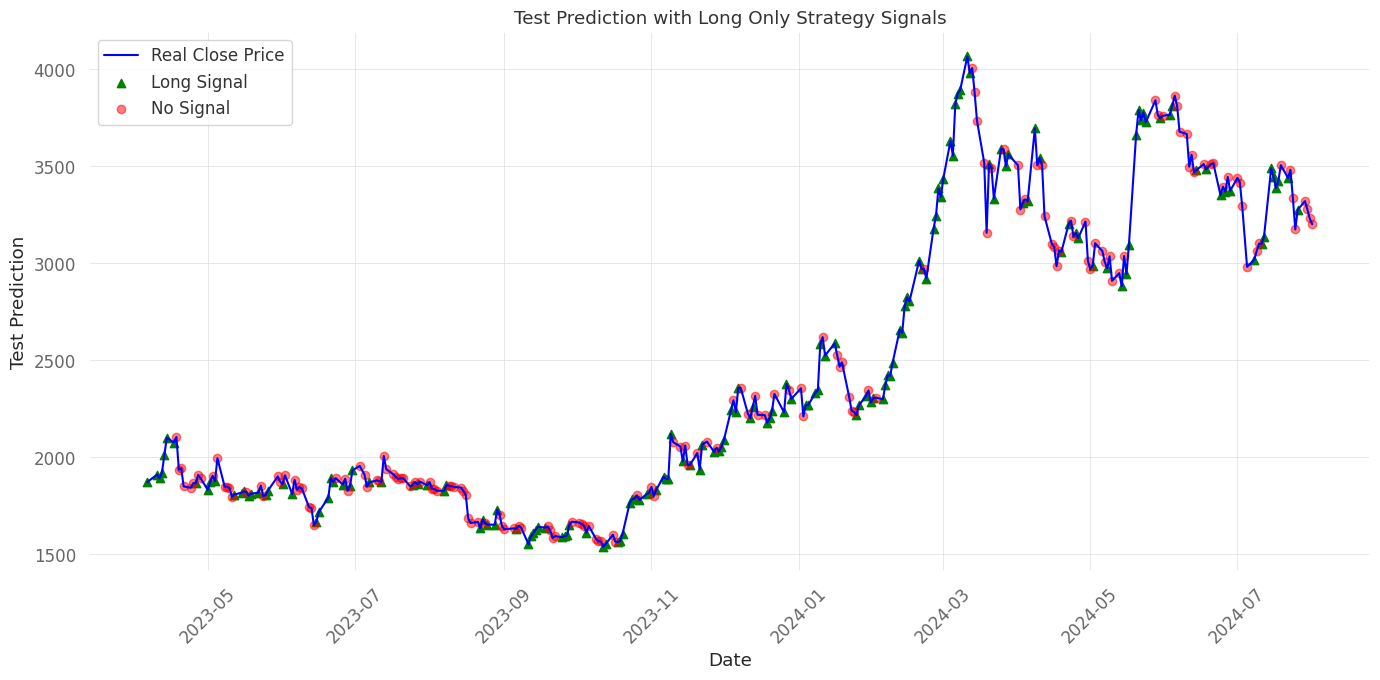

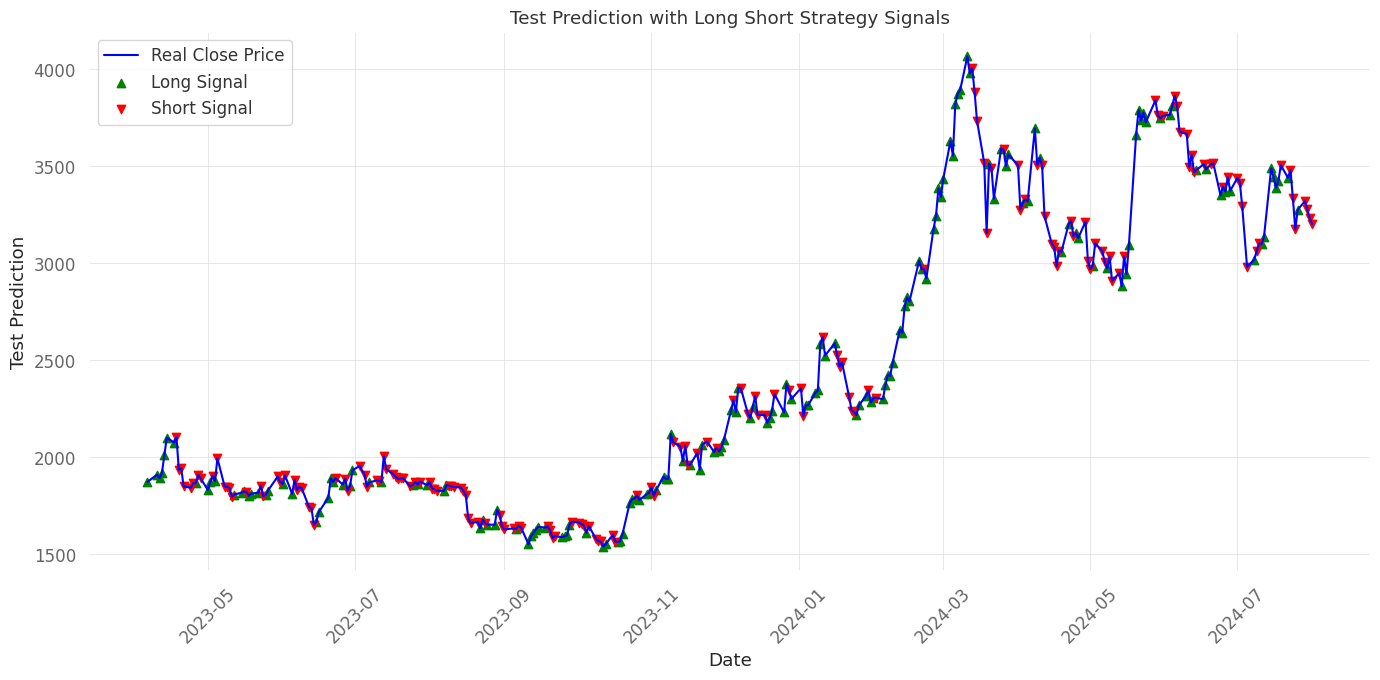

In [ ]:
# Copying prediction results to a new DataFrame
df_prediction = prediction_bayesian_bilstm_df.copy()

# Long-Only
long_only_signal = generate_signals(df_prediction,'Test_Prediction',target='long_only')
df_prediction['Long_Only'] = long_only_signal['Strategy']

# Long-Short
long_short_signal = generate_signals(df_prediction,'Test_Prediction',target='long_short')
df_prediction['Long_Short'] = long_short_signal['Strategy']

# Buy-Hold
df_prediction['Observation'] = y_test
buy_hold_signal = generate_signals(df_prediction,'Observation',target='long_only')
df_prediction['Buy_Hold'] = buy_hold_signal['Strategy']

# Plot the proposed strategies
plot_strategy_signals(df_prediction,'Long Only', strategy='long_only')
plot_strategy_signals(df_prediction,'Long Short', strategy='long_short')

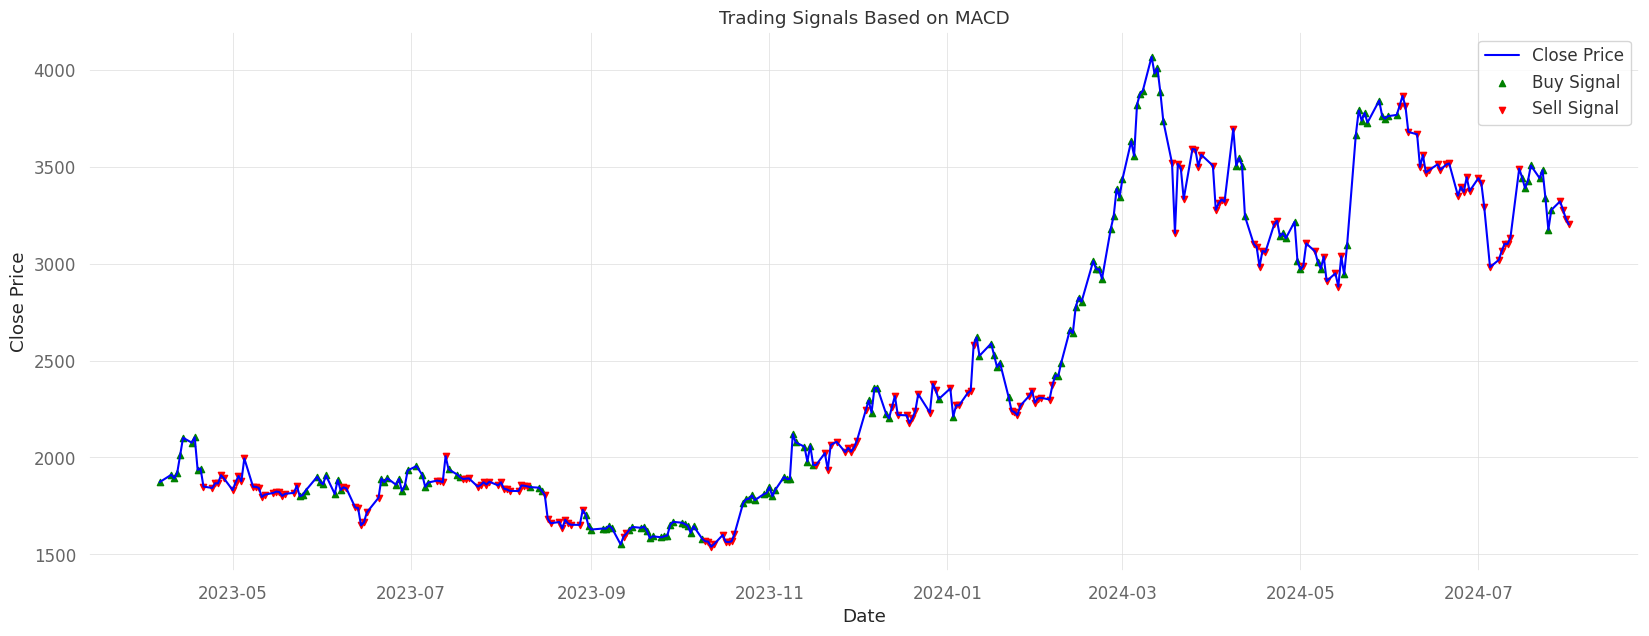

In [ ]:
# Trading strategy based on MACD
# Align with prediction_df index
start_date = df_prediction.index[0]
end_date = df_prediction.index[-1]
filtered_df = eth_data[start_date:end_date]
macd_df = filtered_df[['Close','MACD_Line', 'MACD_Histogram', 'Signal_Line']].copy()

# Shift MACD_line and Signal_Line columns to align with the next time step
macd_df['MACD_line_prev'] = macd_df['MACD_Line'].shift(1)
macd_df['Signal_Line_prev'] = macd_df['Signal_Line'].shift(1)

# Apply the strategy logic
macd_df['MACD_Trading_Signal'] = 1
macd_df.loc[macd_df['MACD_line_prev'] >= macd_df['Signal_Line_prev'], 'MACD_Trading_Signal'] = 1
macd_df.loc[macd_df['MACD_line_prev'] < macd_df['Signal_Line_prev'], 'MACD_Trading_Signal'] = -1

# Drop the temporary columns used for calculation
macd_df.drop(columns=['MACD_line_prev', 'Signal_Line_prev'], inplace=True)

# Add to prediction df
df_prediction['MACD_Trading_Signal'] = macd_df['MACD_Trading_Signal']

# Plot MACD strategy
plot_technical_signals(macd_df, 'Close', 'MACD_Trading_Signal', 'MACD')

**CALCULATING PORTFOLIO VALUE OF EACH INDIVIDUAL STRATEGY**

In [ ]:
# Portfolio Value of each individual strategy
df_portfolio_value = calculate_portfolio_values(df_prediction, start_money=1000)
df_portfolio_value

Return  Long_Only_Return  Long_Short_Return  \
2023-04-06  0.000000          0.000000           0.000000   
2023-04-10  0.020441          0.020441           0.020441   
2023-04-11 -0.009951         -0.009951          -0.009951   
2023-04-12  0.015058          0.015058           0.015058   
2023-04-13  0.047875          0.047875           0.047875   
...              ...               ...                ...   
2024-07-26  0.031982          0.031982           0.031982   
2024-07-29  0.013611          0.000000          -0.013611   
2024-07-30 -0.012610         -0.000000           0.012610   
2024-07-31 -0.014449         -0.000000           0.014449   
2024-08-01 -0.009201         -0.000000           0.009201   

            MACD_Trading_Return  Portfolio_Value_Buy_Hold  \
2023-04-06             0.000000               1000.000000   
2023-04-10             0.020441               1020.441268   
2023-04-11            -0.009951               1010.287179   
2023-04-12             0.015058               1025.499997   
2023-04-13             0.047875               1074.595734   
...                         ...                       ...   
2024-07-26             0.031982               1749.112004   
2024-07-29            -0.013611               1772.918589   
2024-07-30             0.012610               1750.562309   
2024-07-31             0.014449               1725.269182   
2024-08-01             0.009201               1709.394953   

            Portfolio_Value_Long_Only  Portfolio_Value_Long_Short  \
2023-04-06                1000.000000                 1000.000000   
2023-04-10                1020.441268                 1020.441268   
2023-04-11                1010.287179                 1010.287179   
2023-04-12                1025.499997                 1025.499997   
2023-04-13                1074.595734                 1074.595734   
...                               ...                         ...   
2024-07-26                6767.971675                22572.550660   
2024-07-29                6767.971675                22265.323142   
2024-07-30                6767.971675                22546.086060   
2024-07-31                6767.971675                22871.844833   
2024-08-01                6767.971675                23082.289030   

            Portfolio_Value_MACD_Trading  
2023-04-06                   1000.000000  
2023-04-10                   1020.441268  
2023-04-11                   1010.287179  
2023-04-12                   1025.499997  
2023-04-13                   1074.595734  
...                                  ...  
2024-07-26                    746.134028  
2024-07-29                    735.978645  
2024-07-30                    745.259242  
2024-07-31                    756.027175  
2024-08-01                    762.983393  

[332 rows x 8 columns]

**VISUALIZING THE PORTFOLIO VALUE**

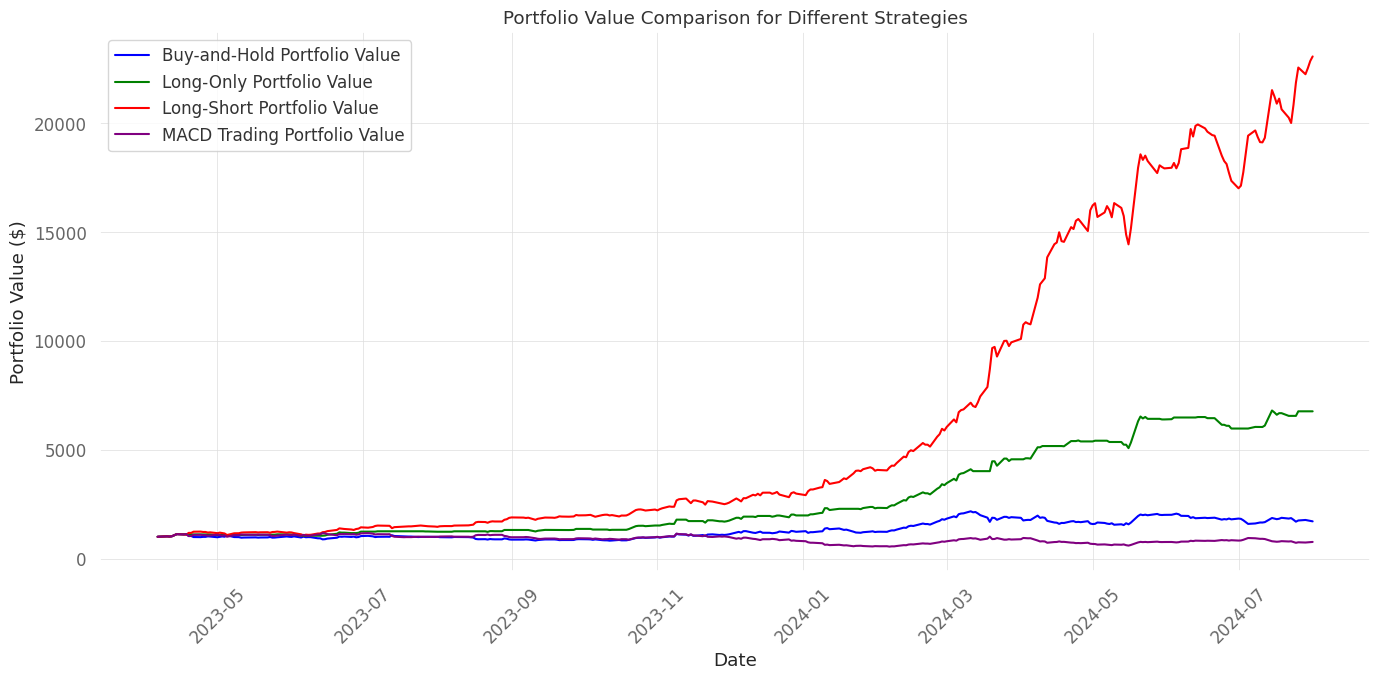

In [ ]:
plot_portfolio_values(df_portfolio_value)

**FULL STATISTIC**

In [ ]:
qs.reports.metrics(df_portfolio_value['Long_Only_Return'], benchmark = df_portfolio_value['Return'],mode="full")

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2023-04-06   2023-04-06
End Period                 2024-08-01   2024-08-01
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       50.0%

Cumulative Return          70.94%       576.8%
CAGR﹪                     32.28%       171.2%

Sharpe                     1.02         3.76
Prob. Sharpe Ratio         88.54%       100.0%
Smart Sharpe               1.01         3.73
Sortino                    1.67         10.55
Smart Sortino              1.65         10.47
Sortino/√2                 1.18         7.46
Smart Sortino/√2           1.17         7.4
Omega                      2.94         2.94

Max Drawdown               -29.15%      -8.48%
Longest DD Days            204          61
Volatility (ann.)          53.68%       40.82%
R^2                        0.62         0.62
Information Ratio          0.19         0.19
Calmar               

In [ ]:
qs.reports.metrics(df_portfolio_value['Long_Short_Return'], benchmark = df_portfolio_value['Return'],mode="full")

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2023-04-06   2023-04-06
End Period                 2024-08-01   2024-08-01
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          70.94%       2,208.23%
CAGR﹪                     32.28%       414.37%

Sharpe                     1.02         4.91
Prob. Sharpe Ratio         88.54%       100.0%
Smart Sharpe               0.96         4.62
Sortino                    1.67         11.61
Smart Sortino              1.57         10.93
Sortino/√2                 1.18         8.21
Smart Sortino/√2           1.11         7.73
Omega                      2.5          2.5

Max Drawdown               -29.15%      -14.7%
Longest DD Days            204          31
Volatility (ann.)          53.68%       51.39%
R^2                        0.04         0.04
Information Ratio          0.19         0.19
Calmar          

In [ ]:
qs.reports.metrics(df_portfolio_value['MACD_Trading_Return'], benchmark = df_portfolio_value['Return'],mode="full")

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2023-04-06   2023-04-06
End Period                 2024-08-01   2024-08-01
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          70.94%       -23.7%
CAGR﹪                     32.28%       -13.16%

Sharpe                     1.02         -0.12
Prob. Sharpe Ratio         88.54%       44.76%
Smart Sharpe               0.96         -0.11
Sortino                    1.67         -0.17
Smart Sortino              1.57         -0.16
Sortino/√2                 1.18         -0.12
Smart Sortino/√2           1.11         -0.11
Omega                      0.98         0.98

Max Drawdown               -29.15%      -53.13%
Longest DD Days            204          394
Volatility (ann.)          53.68%       53.79%
R^2                        0.0          0.0
Information Ratio          -0.05        -0.05
Calmar      